In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import os
import shutil # для копирования рисунков в папку best

from win32com import client
from typing import List, Dict
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

In [2]:
pd.set_option('display.max_columns', None)
# Подключение логирования
logging.getLogger().setLevel(logging.INFO)

In [3]:
Server = client.Dispatch('PX32.OpenServer.1')
Server.SetValue('GAP.EnableNetworkValidation', 0)

0

## Загрузка данных

In [4]:
# Загрузка таблицы с наборами ОФП
ofp_df = pd.read_csv('ofp_sets.csv', encoding='cp1251', sep=';')
ofp_df

,param,res_sat,end_point,exp,table
0,krw,0.99,0.500000,2.000000,1
1,kro,0.00,1.000000,1.000000,1
2,krg,0.00,1.000000,4.000000,1
3,krw,0.10,0.500000,2.000000,2
4,kro,0.10,0.800000,2.000000,2
5,krg,0.00,0.100000,5.000000,2
6,krw,0.10,0.100000,4.000000,3
7,kro,0.10,0.300000,4.000000,3
8,krg,0.00,1.000000,2.000000,3
9,krw,0.41,0.008064,0.183134,4


In [5]:
init_df = pd.read_csv(r'C:\Users\Meledina.YaV\Documents\dev\pressure_for_prosper\pivot_table_shtr_pres_en.csv', 
                 sep=';', encoding='cp1251', parse_dates=['measure_date_new'], dayfirst=False)
well_name = 'W1'

# Оставляем только нужные столбцы в датафрейме
# bhp - Рзаб из файла НТЦ
df = init_df.copy()
df = df[['well_name', 'measure_date_new', 'q_fluid', 
              'wcutting','gas_factor', 'p_bottom_from_intake', 'bhp', 
              'layer_pres_calc', 'layer_pres_research', 'layer_pres_research_count']]

df['measure_date_new'] = pd.to_datetime(df['measure_date_new'])

Формируем срез данных для дальнейшей работы

In [7]:
# Оставляем только скв. НП4
df = df[df['well_name'].str.startswith('4')]
print('Количество скважин до фильтров по пропущенным значениям ='
    ,df['well_name'].unique().shape[0])

df = df.query('gas_factor.notna() \
              and wcutting.notna() \
              and (layer_pres_calc.notna() \
              or layer_pres_research.notna())')

# Установим имя скв. в качестве индекса
df.set_index(['well_name', 'measure_date_new'], inplace=True)
# Упроощаем работу со срезами для мультииндексов
idx = pd.IndexSlice
df.head()

Количество скважин до фильтров по пропущенным значениям = 181


q_fluid   wcutting   gas_factor  \
well_name measure_date_new                                      
40        2021-02-01        59.677419  68.903230  4146.052934   
          2021-03-01        51.785714  67.035710  4265.472837   
          2021-04-01        44.838710  59.870968  3714.614080   
          2021-05-01        44.466667  54.166668  2487.993084   
          2021-06-01        40.792308  60.974228  2935.429590   

                            p_bottom_from_intake         bhp  layer_pres_calc  \
well_name measure_date_new                                                      
40        2021-02-01                   94.958060  100.095850        197.36785   
          2021-03-01                   95.060356  104.047525        188.65390   
          2021-04-01                   99.513870  105.060775        186.42475   
          2021-05-01                  101.012665  105.499850        186.42475   
          2021-06-01                  108.479996  140.423200        183.38500   

                            layer_pres_research  layer_pres_research_count  
well_name measure_date_new                                                  
40        2021-02-01                        NaN                          7  
          2021-03-01                        NaN                          7  
          2021-04-01                        NaN                          7  
          2021-05-01                        NaN                          7  
          2021-06-01                   195.1387                          7

Посмотрим топ-10 скв. по количеству точек Рпл по ГДИ

In [9]:
gis_cnt_df = (df.groupby('well_name')
 .agg({'layer_pres_research_count': 'max'})
 .sort_values(by='layer_pres_research_count', ascending=False)
)
gis_cnt_df.head(10)

,layer_pres_research_count
well_name,
4097,33
4086,28
4087,18
4134,16
4135,16
4136,13
4058,13
4045,12
4064,12


In [10]:
print('Общее количество скв. в датафрейме =',
      df.index.get_level_values(0).unique().shape[0],
      '\nКоличество скв., с начальным ГФ более 300 м3/м3 =',
      df.groupby('well_name').agg({'gas_factor': 'first'}).query('gas_factor > 300').shape[0]
)

Общее количество скв. в датафрейме = 181 
Количество скв., с начальным ГФ более 300 м3/м3 = 79


Создадим папки для сохранения графиков

In [11]:
# Сохраним в переменную название скрипта
file = 'Gap.ipynb'

# Получаем абсолютный путь к скрипту
absolute_path = os.path.abspath(file)

# Путь к директории, в которой находится файл (папка)
path = os.path.dirname(absolute_path)
newpath =r''+path+'\\graph\\'
bestpath = r''+path+'\\best_graph\\'

# Путь для сохранения графиков
if not os.path.exists(newpath):
    # Создадим папку для графиков
    os.makedirs(newpath)

# Путь для сохранения графиков с лучшей настройкой Рпл
if not os.path.exists(bestpath):
    # Создадим папку для графиков
    os.makedirs(bestpath)

In [12]:
class IPRCalculator:

    def __init__(self, server, well_name: str):
        self.server = server
        self.well_name = well_name
        self._bhp = 0
        self.calc_bhp = []
        self.calc_resp = []
        self._best_params = 0

    def calc_pi(self, w_name: str, date, q_fluid: float, wct: float, gor: float, 
                bhp: float, resp: float, source: str, pb: float =300) -> float:
        '''Функция рассчитывает Кпрод через секцию IPR Match.
        pb - давление насыщения'''
        pi_list = []
        self.server.SetValue('GAP.MOD[{PROD}].WELL[{'+ self.well_name +'}].IPR[0].MResPres', 
                            resp) # заносим тест Рпл
        self.server.SetValue('GAP.MOD[{PROD}].WELL[{'+ self.well_name +'}].IPR[0].MWCT', 
                            wct) # заносим тест обв
        self.server.SetValue('GAP.MOD[{PROD}].WELL[{'+ self.well_name +'}].IPR[0].MGOR', 
                            gor) # заносим тест ГФ
        self.server.SetValue('GAP.MOD[{PROD}].WELL[{'+ self.well_name +'}].IPR[0].MPB', 
                            pb) # заносим давление насыщения
        self.server.SetValue('GAP.MOD[{PROD}].WELL[{'+ self.well_name +'}].IPR[0].MLiqRate[0]', 
                            q_fluid) # заносим тест дебит жидкости
        self.server.SetValue('GAP.MOD[{PROD}].WELL[{'+ self.well_name +'}].IPR[0].MPres[0]', 
                            bhp) # заносим тест Рзаб
        # Рассчитаем PI
        self.server.DoCommand('GAP.MOD[{PROD}].WELL[{'+ self.well_name +'}].IPR[0].PIMATCH()')

        if pd.notna(bhp):
            pi = self.server.GetValue('GAP.MOD[{PROD}].WELL[{'+ self.well_name +'}].IPR[0].PI')
        else:
            # Заносим в pi_list нулевой Кпрод, если нет Рзаб
            pi=0

        pi_list = [w_name, date, q_fluid, wct, gor, bhp, resp, source, pi]

        # Создадим в датафрейме новую строку и заполним данными по текущей скв. (списком)
        pi_df.loc[w_name] = pi_list
        # Удалим название скв. из индексов
        pi_df.reset_index(inplace=True, drop=True)
        print(pi_df[pi_df['well_name'] == w_name])

        return pi_df

    def set_ofp(self, ofp_df: pd.DataFrame()):
        '''Функция заносит ОФП в таблицу Rel Perm 2 в секции IPR -> More'''
        # Создадим словарь, где ключи - названия ячеек в GAP, а значения - названия столбцов в табл. ОФП
        ofp_dict = {'RESSAT': 'res_sat',
                    'ENDPOINT': 'end_point',
                    'EXPON': 'exp'}

        # Бежим по строкам в выбранной таблице ОФП
        for _, row in ofp_df.query('table == @table').iterrows():
            # Заносим данные по столбцам в GAP
            for key, value in ofp_dict.items():
                # Заносим ОФП в таблицу Rel Perm 2 в секции IPR -> More
                if row['param'] == 'krw':
                    Server.SetValue(
                        'GAP.MOD[{PROD}].WELL[{W1}].IPR[0].FRACFLOW2.'+ key +'.Krw', 
                        row[value]
                        )
                elif row['param'] == 'kro':
                    Server.SetValue(
                        'GAP.MOD[{PROD}].WELL[{W1}].IPR[0].FRACFLOW2.'+ key +'.Kro', 
                        row[value]
                        )
                elif row['param'] == 'krg':
                    Server.SetValue(
                        'GAP.MOD[{PROD}].WELL[{W1}].IPR[0].FRACFLOW2.'+ key +'.Krg', 
                        row[value]
                        )     
                    
    def fit_bhp(self, x: float, q_fluid: float, wct: float, 
                gor: float, bhp: float, ofp_table: int) -> float:
        '''Функция рассчитывает через секцию IPR в GAP Рзаб,
        возвращает дельту между расчетом и фактом Рзаб'''
    # В секции IPR Layer заполняем текущие показатели скв.
        self.server.SetValue(
            'GAP.MOD[{PROD}].WELL[{' + self.well_name + '}].IPR[0].ResPres', 
            x
        ) # заносим Рпл
        self.server.SetValue(
            'GAP.MOD[{PROD}].WELL[{'+ self.well_name + '}].IPR[0].WCT', 
            wct
        ) # заносим обв
        self.server.SetValue(
            'GAP.MOD[{PROD}].WELL[{' + self.well_name + '}].IPR[0].GOR', 
            gor
        ) # заносим ГФ
        
        # Заносим дебит жидкости в окне Calculate
        # Переведем дебит жидкости из м3/сут в STB/day
        q = str(q_fluid * 6.28981077043211)
        (self.server.DoCommand(
            'GAP.MOD[{PROD}].WELL[{' + self.well_name + '}].IPR[0].IPRCalc('+q+', 1)')
            ) 
        
        self._param = self.server.GetValue(
            'GAP.MOD[{PROD}].WELL[{' + self.well_name + '}].IPR[0].IPRCalcResult.RawVal'
        )
        
        # Из Prosper выгружаются значения str, преобразуем в вещественный
        # Переведем из psig в bara
        self._param = float(self._param) / 14.504 + 1

        return self._param - bhp

    def fit_liq(self, x: float, q_fluid: float, wct: float, gor: float, bhp: float) -> float:
        '''Функция рассчитывает через секцию IPR в GAP дебит жидкости,
        возвращает дельту между расчетом и фактом дебита жидкости'''
    # В секции IPR Layer заполняем текущие показатели скв.
        self.server.SetValue(
            'GAP.MOD[{PROD}].WELL[{' + self.well_name + '}].IPR[0].ResPres', 
            x
        ) # заносим Рпл
        self.server.SetValue(
            'GAP.MOD[{PROD}].WELL[{'+ self.well_name + '}].IPR[0].WCT', 
            wct
        ) # заносим обв
        self.server.SetValue(
            'GAP.MOD[{PROD}].WELL[{' + self.well_name + '}].IPR[0].GOR', 
            gor
        ) # заносим ГФ
        
        # Заносим Рзаб в окне Calculate
        # Переведем Рзаб из bara в psig
        p = str((row['p_bottom_from_intake'] - 1) * 14.504)
        (self.server.DoCommand(
            'GAP.MOD[{PROD}].WELL[{' + self.well_name + '}].IPR[0].IPRCalc('+p+', 0)')
            ) 
        
        self._param = self.server.GetValue(
            'GAP.MOD[{PROD}].WELL[{' + self.well_name + '}].IPR[0].IPRCalcResult.RawVal'
        )
        
        # Из Prosper выгружаются значения str, преобразуем в вещественный
        # Переведем из STB/day в м3/сут
        self._param = float(self._param) / 6.28981077043211
    
        return self._param - q_fluid

    def half_divide_method(
        self, 
        a: List[float], 
        b: List[float],
        f: callable, 
        max_iter: int = 10,
        **kwargs,
    ) -> tuple[float, float]:
        '''Метод половинного деления подбирает параметр в диапазоне [a, b]'''
        
        iter = 0
        x = (a + b) / 2

        while abs(f(x, **kwargs)) >= 0.1 and iter <= max_iter:
            iter += 1
            x = (a + b) / 2
            
            # Чем < Рпл, тем < Рзаб
            # Если расч < факт, то меняем левую границу; если расч > факт, то меняем правую границу
            a, b = (x, b) if f(x, **kwargs) < 0 else (a, x)
        
        # Возвращаем лучшее подобранное Рпл и Рзаб/дебит жидкости
        return x, self._param
    
    def set_params(self, ofp_table: int, err: float) -> Dict:
        '''Запоминаем RMSE и параметры в словаре'''
        # Если словарь пуст или текущая RMSE меньше предыдущей, то обновим словарь, 
        # иначе словарь не меняется
        if not self._best_params or err < self._best_params['err']:
            self._best_params = {'err': err, 'ofp_table': ofp_table}

    def best_params(self) -> Dict:
        '''Определяем лучшие параметры по минимальной RMSE'''
        # Если _best_params содержит значения, то вернем их, иначе None
        if self._best_params:
            return self._best_params['err'], self._best_params['ofp_table']
        return None
    
    def reset_params(self):
        '''Удаляем лучшие параметры при переходе к следующей скв.'''
        self._best_params = None

    def get_index(self, pres_df: pd.DataFrame, w_name: str):
        '''Функция возвращает список мультииндексов по скв.'''
        _idx_list = []
        for idx in pres_df.loc[w_name].index:
            _idx_list.append((w_name, idx))
        return _idx_list

    def create_plot(self, df: pd.DataFrame, pi_df: pd.DataFrame, w_name: str, 
                    path: str, rmse:float, ofp_table: int, date: str ='measure_date_new'):
        ''' Функция создает графики сопоставления фактических и рассчитанных параметров по скв.'''
        sns.color_palette('coolwarm', 20)
        sns.set_style('darkgrid')
        fig = plt.figure(figsize=(15, 15))
        _gor = pi_df['gor'].values[0]
        _pi = pi_df['pi'].values[0]
        
        fig.suptitle(
            f'Скважина №{w_name} \n Начальные параметры: ГФ={round(float(_gor), 1)}, \
Кпрод={round(float(_pi), 3)}',
            fontsize=16, y=0.93)

        # Установка расстояния между таблицами
        plt.subplots_adjust(wspace=0, hspace=0.1)

        ax = plt.subplot(3, 1, 1)
        ax.scatter(x=date, y=df['p_bottom_from_intake'], s=50, label='Факт от Рприем (ШТР)', 
                   color='orange', marker='s')
        ax.scatter(x=date, y=df['calc_bhp'], s=20, label='Расчет')
        ax.set_ylim(min(df['p_bottom_from_intake'].min(), df['calc_bhp'].min()) * 0.9, 
                max(df['p_bottom_from_intake'].max(), df['calc_bhp'].max()) * 1.1)
        ax.set_title('Динамика Рзаб')
        ax.set_xticklabels([])
        ax.set_xlabel('')
        ax.set_ylabel('Рзаб, бара')
        ax.legend()

        ax = plt.subplot(3, 1, 2)
        ax.scatter(x=date, y=df['layer_pres_calc'], s=50, label='Расчет НТЦ', 
                   color='orange', marker='s')
        ax.scatter(x=date, y=df['calc_resp'], s=20, label='Расчет с адаптацией Рзаб')
        ax.scatter(x=date, y=df['layer_pres_research'], s=70, label='ГДИ', 
                   color='m', alpha=0.7)
        ax.set_ylim(min(df['layer_pres_calc'].min(), 
                        df['calc_resp'].min(),
                        df['layer_pres_research'].min()
                        ) * 0.9, 
                    max(df['layer_pres_calc'].max(), 
                        df['calc_resp'].max(), 
                        df['layer_pres_research'].max()
                        ) * 1.1)
        ax.set_title(f'Динамика Рпл (rmse={round(rmse, 1)} бар)')
        ax.set_xticklabels([])
        ax.set_xlabel('')
        ax.set_ylabel('Рпл, бара')
        ax.legend()

        
        ax = plt.subplot(3, 1, 3)
        ax.plot(date, df['q_fluid'], label='Дебит жидкости')
        ax.plot(date, df['wcutting'], label='WCT')
        # Для вспомогательной оси У зададим ось Х от основной оси
        ax3_2 = ax.twinx()
        ax3_2.plot(date, df['gas_factor'], label='GOR', color='green')
        ax.set_title('Динамика фактических показателей из ШТР')
        ax.set_xlabel('Дата')
        ax.legend()
        plt.legend(loc='center right')
        
        plt.savefig(r''+path+str(w_name)+'_tab'+str(ofp_table)+'.png')   
        # Отключим отображение всех рисунков в ячейке вывода
        plt.close('all')  
        

Расчет Рпл с адаптацией Рзаб на факт ШТР:

Алгоритм выполнения расчета по каждой скв.:
1. Расчет начального Кпрод по данным из ШТР. Рзаб берется из ШТР или из ГДИ, в зависимости от того, какие данные появятся раньше по дате в полном объеме. Кпрод фиксируется
2. Задание ОФП. Они будут использоваться для корректировки Кпрод
3. Настройка Рзаб на основе данных из ШТР (дебит жидкости, обв., ГФ., Рпл). Варьируется Рпл, начальное значение берется из файла НТЦ. Используется метод половинного деления с точностью адаптации 0.1 бар. Настройка выполняется на весь период работы скв. (при наличии всех данных для расчета).
4. Расчет среднеквадратической ошибки Рпл по ГДИ и расчетного Рпл.
5. Запоминание лучшей таблицы ОФП и наименьшей среднеквадратической ошибки
6. Формирование итоговой статистики по лучшим ОФП по каждой скв. 


In [101]:
calc_resp, calc_bhp = [], []

df['calc_bhp'] = np.nan
df['calc_resp'] = np.nan

# Создадим датафрейм с данными для расчета Кпрод по всем скв.
pi_df = pd.DataFrame(columns=[
    'well_name', 'date_for_calc_pi', 'q_fluid', 'wct', 
    'gor', 'bhp', 'resp', 'pressure_source', 'pi'
]) 


# Создадим датафрейм с результатами расчета
result_df = pd.DataFrame(columns=['well_name', 'gdi_count','rmse', 'ofp_table']) 

for well_name in tqdm(df.index.get_level_values(0).unique()):
    logging.info(f'\n-----Начат расчет по скв. {well_name}-----')

    # Создадим датафрейм c расчетными давлениями с мультииндексом по скв. и дате
    # Этот датафрейм нужен для сохранения давлений по всем вариантам ОФП
    all_pressure_df = pd.DataFrame(
        columns=['well_name', 
                'measure_date_new', 
                'ofp_table', 
                'calc_resp', 
                'calc_bhp']).set_index(['well_name', 'measure_date_new', 'ofp_table'])
    calculator = IPRCalculator(server=Server, well_name='W1')
    well_df = df.loc[well_name]

    # Обработка случаев с отсутствующими давлениями
    if well_df.query('layer_pres_research.notna()').shape[0] == 0:
        logging.info('\nОтсутствует Рпл по ГДИ, скв. не будет рассчитана')
        continue
    elif well_df.query('p_bottom_from_intake.notna()').shape[0] == 0:
        logging.info('\nОтсутствует Рзаб по ШТР, скв. не будет рассчитана')
        continue
    else:
        # Если Рзаб от Рприем указан в более раннюю дату, чем Рзаб по ГДИ, 
        # то берем Рзаб от Рприем и Рпл, рассчитанное НТЦ, иначе Рзаб и Рпл по ГДИ
        if (well_df.query('p_bottom_from_intake.notna()').index.get_level_values(0)[0] 
            < well_df.query('layer_pres_research.notna()').index.get_level_values(0)[0]):
            filter = 'p_bottom_from_intake.notna()'
            bhp = well_df.query(filter)['p_bottom_from_intake'][0]
            bhp_name = 'p_bottom_from_intake'
            resp = well_df.query(filter)['layer_pres_calc'][0]
            source = 'shtr'
        elif (well_df.query('p_bottom_from_intake.notna()').index.get_level_values(0)[0] 
            > well_df.query('layer_pres_research.notna()').index.get_level_values(0)[0]):
            filter = 'layer_pres_research.notna()'
            bhp = well_df.query(filter)['bhp'][0]
            bhp_name = 'bhp'
            resp = well_df.query(filter)['layer_pres_research'][0]
            source = 'gdi'
        else:
            pass

    try:
        # Заполним секцию Match IPR Data тестовыми данными и рассчитаем начальный Кпрод
        # Создадим датафрейм с данными для расчета Кпрод по всем скв.
        pi_df = calculator.calc_pi(
            w_name=well_name,
            date=well_df.query(filter).index.get_level_values(0)[0], #вытащим дату из мульииндекса
            q_fluid=well_df.query(filter)['q_fluid'][0],
            wct=well_df.query(filter)['wcutting'][0],
            gor=well_df.query(filter)['gas_factor'][0],
            bhp=bhp,
            resp=resp,
            source=source,
            pb=300
        )

    except IndexError:
        logging.info(f'По скв. {well_name} нет ни одного значения Рзаб')
        continue

    # Бежим по таблицам ОФП
    for table in ofp_df['table'].unique():
        logging.info(f'Заносятся данные из таблицы ОФП № {table}')
        
        # Заносим ОФП в таблицу IPR -> More
        calculator.set_ofp(ofp_df)
        # Бежим по строчкам датафрейма из ШТР
        for _idx, row in tqdm(well_df.iterrows(), total=well_df.shape[0]):

            # Удалим rmse и номер таблицы ОФП, 
            # чтобы при неудачном расчете не записывать старые значения
            err, best_table = np.nan, np.nan

            val1, val2 = calculator.half_divide_method(
                a=50,
                b=200,
                f=calculator.fit_bhp, 
                max_iter=15,
                wct=row['wcutting'],
                gor=row['gas_factor'],
                q_fluid=row['q_fluid'],
                bhp=row['p_bottom_from_intake'],
                ofp_table=table
            )

            # Создадим столбец с параметрами, рассчитанным в GAP
            well_df.loc[_idx, 'calc_resp'] = val1
            well_df.loc[_idx, 'calc_bhp'] = val2

            # Добавим рассчитанные давления по всем вариантам ОФП в датафрейм с мультииндексом
            # Этот датафрейм нужен для сохранения лучших давлений
            all_pressure_df.loc[(well_name, _idx, table), 
                    ['calc_resp', 'calc_bhp']] = [val1, val2]

        try:
            # Занулим ошибку, чтобы она не переносилась с предыдущей скв. в случае, 
            # когда по текущей скв. не получается рассчитать rmse
            rmse = 0

            # Найдем корень из среднеквадратичной ошибки между факт.Рпл по ГДИ и рассчетным Рпл
            # rmse считаем только по строкам
            rmse = mean_squared_error(
                well_df.query(f'layer_pres_research.notna()\
                            and {bhp_name}.notna()')['layer_pres_research'],
                well_df.query(f'layer_pres_research.notna()\
                            and {bhp_name}.notna()')['calc_resp'],
                squared=False)
                
            # Запомним rmse в словаре
            calculator.set_params(ofp_table=table, err=rmse)  
            logging.info(f'Среднеквадратичная ошибка Рпл: {round(rmse, 1)} бар')
            # Запомним лучшую среднеквадратическую ошибку и номер таблицы ОФП ей соответствующую
            err, best_table = calculator.best_params()

        except ValueError:
            print('\nОтсутствует Рпл по ГДИ')
        # Отобразим графики сопоставления фактических и рассчитанных параметров скв.
        calculator.create_plot(df=well_df,
                            pi_df=pi_df.query('well_name == @well_name'),
                            w_name=well_name,
                            path=newpath, 
                            rmse=rmse,
                            ofp_table=table,
                            date=well_df.index.get_level_values(0))
    # Создадим в датафрейме новую строку и заполним данными по текущей скв. (списком)
    result_df.loc[well_name] = [
        well_name,
        gis_cnt_df.loc[well_name, 'layer_pres_research_count'], 
        err,
        best_table
        ]
    logging.info(f'!!!Лучшее решение: rmse {round(err, 1)} бар с табл. ОФП № {best_table}')

    all_pressure_df.reset_index(2, inplace=True)
    # Сформируем список уникальных мультииндексов (скв., дата) по текущей скв.
    multiindex = calculator.get_index(all_pressure_df, well_name)
    # Создадим в датафрейме новую строку и 
    # заполним лучшими рассчитанными давлениями по текущей скв. (списком)
    df.loc[
        multiindex, ['calc_resp', 'calc_bhp']
        ] = all_pressure_df.loc[multiindex].query(
            'ofp_table == @best_table'
            )[['calc_resp', 'calc_bhp']]

    try:
        shutil.copy2(r''+newpath+str(well_name)+'_tab'+str(best_table)+'.png',
                    r''+bestpath+str(well_name)+'_tab'+str(best_table)+'.png')
    except:
        logging.info(f'По скв. {well_name} не удалось рассчитать rmse, \
т.к. отсутствуют данные в дату ГДИ')
    # Удалим лучшие параметры при переходе на другую скв. 
    calculator.reset_params()
    logging.info(f'\n-----Закончен расчет по скв. {well_name}-----\n')

  0%|          | 0/181 [00:00<?, ?it/s]INFO:root:
-----Начат расчет по скв. 40-----
INFO:root:Заносятся данные из таблицы ОФП № 1


  well_name date_for_calc_pi    q_fluid       wct          gor       bhp  \
0        40       2021-02-01  59.677419  68.90323  4146.052934  94.95806   

        resp pressure_source           pi  
0  197.36785            shtr  0.655890073  


100%|██████████| 42/42 [00:30<00:00,  1.39it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 44.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 42/42 [00:27<00:00,  1.56it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 39.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 42/42 [00:12<00:00,  3.35it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 44.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 42/42 [00:13<00:00,  3.15it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 56.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 42/42 [00:21<00:00,  1.93it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 32.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 44.3 бар
INFO:root:!!!Лучшее решение: rmse 32.1 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 40-----

  1%|          | 1/181 [02:27<7:21:55, 147.31s/it]INFO:root:
-----Начат ра

  well_name date_for_calc_pi     q_fluid  wct         gor     bhp       resp  \
1      4001       2017-05-01  440.333333  1.0  720.372818  141.92  176.29225   

  pressure_source            pi  
1            shtr  14.015144839  


100%|██████████| 88/88 [01:11<00:00,  1.23it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 88/88 [01:11<00:00,  1.23it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 88/88 [01:02<00:00,  1.40it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 88/88 [01:01<00:00,  1.42it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 88/88 [01:00<00:00,  1.44it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 88/88 [01:00<00:00,  1.45it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.4 бар
INFO:root:!!!Лучшее решение: rmse 14.2 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4001-----

  1%|          | 2/181 [09:04<14:37:38, 294.18s/it]INFO:root:
-----Начат

  well_name date_for_calc_pi   q_fluid        wct          gor     bhp  \
2     4001D       2022-09-07  108.9556  12.430401  3987.197009  141.92   

        resp pressure_source           pi  
2  176.29225            shtr  3.436410651  


100%|██████████| 24/24 [00:15<00:00,  1.56it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 37.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 24/24 [00:15<00:00,  1.52it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 37.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 24/24 [00:16<00:00,  1.41it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 38.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 24/24 [00:17<00:00,  1.35it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 38.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 24/24 [00:17<00:00,  1.36it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 37.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 24/24 [00:18<00:00,  1.32it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 37.9 бар
INFO:root:!!!Лучшее решение: rmse 37.9 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4001D-----

  2%|▏         | 3/181 [10:54<10:23:43, 210.25s/it]INFO:root:
-----Нача

  well_name date_for_calc_pi     q_fluid        wct         gor    bhp  \
3      4003       2017-06-01  219.774194  39.935482  231.377947  85.17   

         resp pressure_source           pi  
3  156.128575            shtr  3.626849944  


100%|██████████| 86/86 [00:58<00:00,  1.48it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 86/86 [01:02<00:00,  1.38it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 86/86 [00:59<00:00,  1.45it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 86/86 [00:58<00:00,  1.48it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 86/86 [00:58<00:00,  1.46it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 19.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 86/86 [00:59<00:00,  1.45it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.3 бар
INFO:root:!!!Лучшее решение: rmse 8.2 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4003-----

  2%|▏         | 4/181 [16:58<13:19:33, 271.04s/it]INFO:root:
-----Начат расч

  well_name date_for_calc_pi   q_fluid  wct         gor     bhp        resp  \
4      4024       2020-02-01  66.16129  1.0  429.495203  90.166  112.558825   

  pressure_source           pi  
4             gdi  3.238525263  


100%|██████████| 61/61 [00:35<00:00,  1.70it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 61/61 [00:35<00:00,  1.70it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 61/61 [00:36<00:00,  1.68it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 61/61 [00:36<00:00,  1.68it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 61/61 [00:32<00:00,  1.87it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 61/61 [00:34<00:00,  1.78it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.4 бар
INFO:root:!!!Лучшее решение: rmse 8.4 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4024-----

  3%|▎         | 6/181 [20:37<9:00:30, 185.32s/it] INFO:root:
-----Начат расчет

  well_name date_for_calc_pi     q_fluid       wct        gor        bhp  \
5      4025       2018-10-13  293.111111  1.222222  155.05889  132.51985   

         resp pressure_source           pi  
5  181.865125             gdi  6.745920283  


100%|██████████| 71/71 [00:34<00:00,  2.08it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 29.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 71/71 [00:33<00:00,  2.10it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 29.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 71/71 [00:34<00:00,  2.05it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 29.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 71/71 [00:35<00:00,  2.02it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 29.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 71/71 [00:33<00:00,  2.10it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 31.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 71/71 [00:32<00:00,  2.15it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 29.2 бар
INFO:root:!!!Лучшее решение: rmse 29.2 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4025-----

  4%|▍         | 7/181 [24:09<9:18:52, 192.72s/it]INFO:root:
-----Начат 

  well_name date_for_calc_pi     q_fluid  wct         gor     bhp        resp  \
6      4026       2020-07-01  117.966667  1.0  910.633458  119.68  151.872925   

  pressure_source           pi  
6            shtr  4.042073855  


100%|██████████| 73/73 [00:31<00:00,  2.29it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 73/73 [00:32<00:00,  2.26it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 73/73 [00:33<00:00,  2.21it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 73/73 [00:33<00:00,  2.17it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 2.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 73/73 [00:29<00:00,  2.49it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 1.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 73/73 [00:33<00:00,  2.20it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.2 бар
INFO:root:!!!Лучшее решение: rmse 0.2 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4026-----

  4%|▍         | 8/181 [27:30<9:21:52, 194.87s/it]INFO:root:
-----Начат расчет 

  well_name date_for_calc_pi     q_fluid       wct          gor         bhp  \
7      4036       2017-09-01  426.354839  1.129032  1039.526264  152.480875   

         resp pressure_source            pi  
7  171.529975             gdi  23.530929234  


100%|██████████| 88/88 [00:30<00:00,  2.84it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 23.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 88/88 [00:29<00:00,  2.99it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 23.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 88/88 [00:30<00:00,  2.90it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 88/88 [00:30<00:00,  2.92it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 88/88 [00:30<00:00,  2.89it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 23.3 бар
INFO:root:!!!Лучшее решение: rmse 22.6 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4036-----

  7%|▋         | 12/181 [30:40<4:53:05, 104.06s/it]INFO:root:
-----Начат

  well_name date_for_calc_pi     q_fluid  wct          gor        bhp  \
8     4036D       2022-05-10  133.928571  9.4  1721.468112  156.30714   

      resp pressure_source           pi  
8  175.279            shtr  7.384094340  


100%|██████████| 27/27 [00:18<00:00,  1.50it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 11.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 27/27 [00:15<00:00,  1.74it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 27/27 [00:16<00:00,  1.65it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 27/27 [00:16<00:00,  1.66it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 27/27 [00:15<00:00,  1.69it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 16.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 27/27 [00:16<00:00,  1.61it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 11.6 бар
INFO:root:!!!Лучшее решение: rmse 9.2 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4036D-----

  7%|▋         | 13/181 [32:27<4:52:49, 104.58s/it]INFO:root:
-----Начат 

  well_name date_for_calc_pi     q_fluid  wct          gor       bhp  \
9      4037       2017-09-01  346.387097  1.0  1557.603542  156.2299   

        resp pressure_source            pi  
9  170.21275             gdi  25.701773172  


100%|██████████| 87/87 [00:04<00:00, 21.34it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 59.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 87/87 [00:04<00:00, 20.05it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 59.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 87/87 [00:04<00:00, 20.78it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 59.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 87/87 [00:04<00:00, 20.49it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 59.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 87/87 [00:04<00:00, 17.78it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 59.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 87/87 [00:04<00:00, 18.28it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 59.2 бар
INFO:root:!!!Лучшее решение: rmse 59.2 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4037-----

  8%|▊         | 14/181 [33:03<4:11:46, 90.46s/it] INFO:root:
-----Начат

   well_name date_for_calc_pi    q_fluid       wct         gor       bhp  \
10      4043       2023-07-19  94.166667  1.843333  717.237869  156.2299   

         resp pressure_source           pi  
10  170.21275             gdi  6.985110268  


100%|██████████| 14/14 [00:09<00:00,  1.45it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 39.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 14/14 [00:08<00:00,  1.62it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 39.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 14/14 [00:09<00:00,  1.52it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 39.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 14/14 [00:08<00:00,  1.56it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 39.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 14/14 [00:08<00:00,  1.60it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 39.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 14/14 [00:09<00:00,  1.48it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 39.3 бар
INFO:root:!!!Лучшее решение: rmse 39.0 бар с табл. ОФП № 2
INFO:root:
-----Закончен расчет по скв. 4043-----

  8%|▊         | 15/181 [34:04<3:51:51, 83.81s/it]INFO:root:
-----Начат 

   well_name date_for_calc_pi  q_fluid   wct        gor       bhp       resp  \
11      4044       2023-03-21  113.625  35.5  174.39799  156.2299  170.21275   

   pressure_source           pi  
11             gdi  8.327381455  


100%|██████████| 18/18 [00:10<00:00,  1.69it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 19.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 18/18 [00:10<00:00,  1.66it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 20.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 18/18 [00:10<00:00,  1.76it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 19.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 18/18 [00:11<00:00,  1.60it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 19.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 18/18 [00:09<00:00,  1.81it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 20.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 18/18 [00:10<00:00,  1.73it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 19.8 бар
INFO:root:!!!Лучшее решение: rmse 19.0 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4044-----

  9%|▉         | 16/181 [35:15<3:41:50, 80.67s/it]INFO:root:
-----Начат 

   well_name date_for_calc_pi  q_fluid        wct        gor         bhp  \
12      4045       2018-05-21  123.808  38.129997  89.422025  119.499588   

        resp pressure_source            pi  
12  128.6695             gdi  13.778275531  


100%|██████████| 76/76 [00:32<00:00,  2.34it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 56.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 76/76 [00:30<00:00,  2.50it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 51.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 76/76 [00:29<00:00,  2.61it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 59.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 76/76 [00:33<00:00,  2.25it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 59.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 76/76 [00:30<00:00,  2.49it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 46.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 76/76 [00:32<00:00,  2.32it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 56.8 бар
INFO:root:!!!Лучшее решение: rmse 46.7 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 4045-----

  9%|▉         | 17/181 [38:31<5:01:52, 110.44s/it]INFO:root:
-----Начат

   well_name date_for_calc_pi     q_fluid    wct          gor         bhp  \
13     4045D       2022-06-30  131.669998  23.43  1965.011111  119.499588   

        resp pressure_source            pi  
13  128.6695             gdi  14.721306113  


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 40.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 26/26 [00:15<00:00,  1.66it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 40.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 26/26 [00:17<00:00,  1.50it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 40.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 26/26 [00:15<00:00,  1.73it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 40.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 26/26 [00:15<00:00,  1.64it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 40.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 26/26 [00:19<00:00,  1.31it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 40.5 бар
INFO:root:!!!Лучшее решение: rmse 40.2 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4045D-----

 10%|▉         | 18/181 [40:22<5:00:19, 110.55s/it]INFO:root:
-----Нача

   well_name date_for_calc_pi  q_fluid        wct        gor         bhp  \
14      4048       2022-07-20   142.47  12.078182  638.05322  119.499588   

        resp pressure_source            pi  
14  128.6695             gdi  15.984900003  


100%|██████████| 26/26 [00:15<00:00,  1.68it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 26/26 [00:14<00:00,  1.76it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 26/26 [00:16<00:00,  1.55it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 26/26 [00:15<00:00,  1.64it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 26/26 [00:15<00:00,  1.69it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 10.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 26/26 [00:15<00:00,  1.65it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.1 бар
INFO:root:!!!Лучшее решение: rmse 8.2 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4048-----

 12%|█▏        | 21/181 [42:03<3:05:12, 69.45s/it] INFO:root:
-----Начат расче

   well_name date_for_calc_pi  q_fluid   wct         gor       bhp  \
15      4054       2017-09-24  483.875  1.25  120.957622  106.7833   

          resp pressure_source           pi  
15  184.094275             gdi  7.681203201  


100%|██████████| 61/61 [00:19<00:00,  3.11it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 35.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 61/61 [00:18<00:00,  3.22it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 34.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 61/61 [00:15<00:00,  3.81it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 34.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 61/61 [00:29<00:00,  2.08it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 40.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 61/61 [00:17<00:00,  3.48it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 35.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 61/61 [00:17<00:00,  3.42it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 35.1 бар
INFO:root:!!!Лучшее решение: rmse 34.0 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4054-----

 13%|█▎        | 23/181 [44:09<2:57:10, 67.28s/it]INFO:root:
-----Начат 

   well_name date_for_calc_pi     q_fluid       wct          gor       bhp  \
16      4055       2019-08-01  233.645161  4.709677  1109.766612  108.8098   

          resp pressure_source           pi  
16  197.671825             gdi  3.262391959  


100%|██████████| 88/88 [00:08<00:00,  9.99it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 46.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 88/88 [00:08<00:00, 10.67it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 46.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 88/88 [00:14<00:00,  6.21it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 46.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 88/88 [00:15<00:00,  5.66it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 46.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 88/88 [00:10<00:00,  8.33it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 46.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 88/88 [00:09<00:00,  9.49it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 46.3 бар
INFO:root:!!!Лучшее решение: rmse 46.3 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4055-----

 13%|█▎        | 24/181 [45:25<3:00:06, 68.83s/it]INFO:root:
-----Начат 

   well_name date_for_calc_pi     q_fluid        wct          gor        bhp  \
17     4055D       2022-08-01  207.654839  15.311934  1559.467196  140.60103   

        resp pressure_source           pi  
17  169.1995            shtr  7.766867909  


100%|██████████| 25/25 [00:15<00:00,  1.57it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 25/25 [00:12<00:00,  2.06it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 25/25 [00:14<00:00,  1.73it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 25/25 [00:13<00:00,  1.87it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 7.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 25/25 [00:13<00:00,  1.85it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 18.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 25/25 [00:13<00:00,  1.90it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.7 бар
INFO:root:!!!Лучшее решение: rmse 7.3 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4055D-----

 14%|█▍        | 25/181 [46:57<3:12:08, 73.90s/it]INFO:root:
-----Начат ра

   well_name date_for_calc_pi  q_fluid     wct         gor        bhp  \
18     4056D       2022-08-24   135.25  15.215  2507.43828  140.60103   

        resp pressure_source           pi  
18  169.1995            shtr  5.059036382  


100%|██████████| 25/25 [00:13<00:00,  1.83it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 10.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 25/25 [00:14<00:00,  1.72it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 25/25 [00:14<00:00,  1.75it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 25/25 [00:13<00:00,  1.82it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 10.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 13.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 25/25 [00:25<00:00,  1.04s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 10.7 бар
INFO:root:!!!Лучшее решение: rmse 9.1 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4056D-----

 15%|█▍        | 27/181 [48:47<2:51:22, 66.77s/it]INFO:root:
-----Начат р

   well_name date_for_calc_pi     q_fluid  wct         gor        bhp  \
19     4057D       2023-05-18  113.230769  1.8  220.131817  140.60103   

        resp pressure_source           pi  
19  169.1995            shtr  4.275588643  


100%|██████████| 15/15 [00:18<00:00,  1.20s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 16.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 15/15 [00:16<00:00,  1.07s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 16.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 15/15 [00:13<00:00,  1.14it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 16.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 15/15 [00:15<00:00,  1.05s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 16.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 16.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 15/15 [00:15<00:00,  1.05s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 16.1 бар
INFO:root:!!!Лучшее решение: rmse 16.1 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4057D-----

 16%|█▌        | 29/181 [50:30<2:35:21, 61.32s/it]INFO:root:
-----Начат

   well_name date_for_calc_pi  q_fluid  wct         gor         bhp  \
20      4058       2020-10-01     81.4  1.0  3525.48848  161.802775   

         resp pressure_source           pi  
20  171.34759             gdi  8.742560890  


100%|██████████| 63/63 [00:04<00:00, 13.44it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 42.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 63/63 [00:03<00:00, 18.88it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 42.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 63/63 [00:05<00:00, 11.71it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 42.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 63/63 [00:04<00:00, 13.42it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 42.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 63/63 [00:02<00:00, 24.07it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 42.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 63/63 [00:04<00:00, 12.97it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 42.8 бар
INFO:root:!!!Лучшее решение: rmse 42.8 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4058-----

 17%|█▋        | 30/181 [51:05<2:20:54, 55.99s/it]INFO:root:
-----Начат 

   well_name date_for_calc_pi    q_fluid        wct           gor       bhp  \
21     4059D       2023-03-08  34.857143  14.616667  10113.439846  149.7411   

        resp pressure_source           pi  
21  162.7147            shtr  2.771512368  


100%|██████████| 17/17 [00:16<00:00,  1.06it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 42.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 17/17 [00:15<00:00,  1.11it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 42.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 17/17 [00:16<00:00,  1.01it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 43.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 17/17 [00:14<00:00,  1.17it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 40.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 17/17 [00:14<00:00,  1.17it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 42.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 17/17 [00:14<00:00,  1.20it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 42.9 бар
INFO:root:!!!Лучшее решение: rmse 40.0 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4059D-----

 18%|█▊        | 32/181 [52:47<2:14:17, 54.07s/it]INFO:root:
-----Начат

   well_name date_for_calc_pi     q_fluid        wct          gor        bhp  \
22      4064       2019-07-01  163.539656  29.140345  1207.173816  91.077925   

          resp pressure_source           pi  
22  137.484775             gdi  3.989875605  


100%|██████████| 83/83 [00:46<00:00,  1.78it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 83/83 [00:52<00:00,  1.58it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 83/83 [00:49<00:00,  1.69it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 18.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 83/83 [00:49<00:00,  1.67it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 83/83 [00:53<00:00,  1.54it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 83/83 [00:47<00:00,  1.74it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.2 бар
INFO:root:!!!Лучшее решение: rmse 15.3 бар с табл. ОФП № 2
INFO:root:
-----Закончен расчет по скв. 4064-----

 18%|█▊        | 33/181 [57:54<4:22:51, 106.56s/it]INFO:root:
-----Начат

   well_name date_for_calc_pi     q_fluid  wct          gor         bhp  \
23      4065       2019-07-01  254.266667  1.0  1470.620787  119.246275   

        resp pressure_source           pi  
23  197.9758             gdi  3.917529979  


100%|██████████| 84/84 [00:23<00:00,  3.51it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 53.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 84/84 [00:19<00:00,  4.41it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 53.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 84/84 [00:20<00:00,  4.04it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 53.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 84/84 [00:18<00:00,  4.66it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 53.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 84/84 [00:18<00:00,  4.52it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 53.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 84/84 [00:20<00:00,  4.17it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 53.2 бар
INFO:root:!!!Лучшее решение: rmse 53.2 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4065-----

 19%|█▉        | 35/181 [1:00:03<3:41:20, 90.96s/it]INFO:root:
-----Нача

   well_name date_for_calc_pi     q_fluid        wct         gor         bhp  \
24     4065D       2022-06-25  160.178571  19.105715  1902.75653  119.246275   

        resp pressure_source           pi  
24  197.9758             gdi  2.403567635  


100%|██████████| 26/26 [00:24<00:00,  1.05it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 41.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 26/26 [00:27<00:00,  1.04s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 41.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 26/26 [00:26<00:00,  1.03s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 41.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 26/26 [00:21<00:00,  1.18it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 38.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 26/26 [00:32<00:00,  1.24s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 41.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 26/26 [00:22<00:00,  1.13it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 41.7 бар
INFO:root:!!!Лучшее решение: rmse 38.8 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4065D-----

 20%|█▉        | 36/181 [1:02:48<4:17:04, 106.38s/it]INFO:root:
-----На

   well_name date_for_calc_pi  q_fluid        wct          gor         bhp  \
25     4066D       2022-06-26    126.5  31.423334  1537.146203  119.246275   

        resp pressure_source           pi  
25  197.9758             gdi  1.861596066  


100%|██████████| 26/26 [00:23<00:00,  1.09it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 42.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 26/26 [00:30<00:00,  1.16s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 44.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 26/26 [00:27<00:00,  1.04s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 37.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 26/26 [00:29<00:00,  1.15s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 29.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 26/26 [00:48<00:00,  1.87s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 44.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 26/26 [00:28<00:00,  1.09s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 42.5 бар
INFO:root:!!!Лучшее решение: rmse 29.6 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4066D-----

 21%|██        | 38/181 [1:06:07<4:07:21, 103.79s/it]INFO:root:
-----На

   well_name date_for_calc_pi  q_fluid  wct         gor         bhp     resp  \
26      4067       2017-05-01    763.7  1.0  348.415738  136.674175  159.067   

   pressure_source            pi  
26             gdi  36.359614156  


100%|██████████| 88/88 [00:45<00:00,  1.92it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 40.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 88/88 [00:50<00:00,  1.74it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 39.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 88/88 [00:51<00:00,  1.72it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 40.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 88/88 [00:46<00:00,  1.90it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 38.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 88/88 [00:44<00:00,  1.96it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 39.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 88/88 [00:50<00:00,  1.75it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 40.2 бар
INFO:root:!!!Лучшее решение: rmse 38.7 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4067-----

 22%|██▏       | 39/181 [1:11:05<5:42:43, 144.81s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi  q_fluid  wct          gor       bhp  \
27      4068       2020-07-01    142.0  1.0  1460.894884  132.7225   

          resp pressure_source           pi  
27  180.152733             gdi  3.387169636  


100%|██████████| 77/77 [00:30<00:00,  2.50it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 57.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 77/77 [00:35<00:00,  2.14it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 57.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 77/77 [00:32<00:00,  2.38it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 57.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 77/77 [00:32<00:00,  2.34it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 57.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 77/77 [00:34<00:00,  2.21it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 57.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 77/77 [00:31<00:00,  2.44it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 57.1 бар
INFO:root:!!!Лучшее решение: rmse 57.1 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4068-----

 23%|██▎       | 41/181 [1:14:33<5:02:07, 129.48s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi     q_fluid  wct         gor       bhp  \
28      4075       2017-07-01  924.966667  1.1  151.558337  129.0748   

         resp pressure_source            pi  
28  173.04985             gdi  23.686022972  


100%|██████████| 87/87 [00:52<00:00,  1.65it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 28.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 87/87 [00:50<00:00,  1.71it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 27.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 87/87 [00:55<00:00,  1.57it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 28.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 87/87 [00:50<00:00,  1.72it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 27.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 87/87 [00:49<00:00,  1.76it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 27.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 87/87 [00:47<00:00,  1.84it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 28.5 бар
INFO:root:!!!Лучшее решение: rmse 27.6 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 4075-----

 24%|██▍       | 44/181 [1:19:48<4:30:44, 118.58s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi     q_fluid       wct        gor        bhp  \
29     4075D       2022-11-01  148.725806  3.050968  942.65212  158.16393   

         resp pressure_source            pi  
29  170.61805            shtr  12.330491590  


100%|██████████| 21/21 [00:20<00:00,  1.05it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 6.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 21/21 [00:22<00:00,  1.09s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 8.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 21/21 [00:21<00:00,  1.04s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 4.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 21/21 [00:19<00:00,  1.07it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 11.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 21/21 [00:21<00:00,  1.02s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 9.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 21/21 [00:19<00:00,  1.07it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 6.1 бар
INFO:root:!!!Лучшее решение: rmse 4.8 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4075D-----

 25%|██▍       | 45/181 [1:22:04<4:35:34, 121.58s/it]INFO:root:
-----Начат ра

   well_name date_for_calc_pi     q_fluid        wct         gor      bhp  \
30     4076D       2022-08-16  171.426875  15.838125  435.154134  158.924   

          resp pressure_source            pi  
30  171.732625            shtr  13.771992098  


100%|██████████| 24/24 [00:25<00:00,  1.06s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 25.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 24/24 [00:24<00:00,  1.03s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 27.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 24/24 [00:22<00:00,  1.06it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 23.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 24/24 [00:23<00:00,  1.01it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 20.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 24/24 [00:23<00:00,  1.02it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 29.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 24/24 [00:19<00:00,  1.22it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 25.5 бар
INFO:root:!!!Лучшее решение: rmse 20.9 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4076D-----

 26%|██▌       | 47/181 [1:24:32<3:56:17, 105.80s/it]INFO:root:
-----На

   well_name date_for_calc_pi    q_fluid      wct          gor        bhp  \
31     4077D       2022-07-14  98.705882  4.22353  4370.231078  162.32875   

         resp pressure_source           pi  
31  180.34525            shtr  5.722792870  


100%|██████████| 24/24 [00:24<00:00,  1.04s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 21.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 24/24 [00:23<00:00,  1.01it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 24/24 [00:23<00:00,  1.04it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 20.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 24/24 [00:26<00:00,  1.12s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 22.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 24/24 [00:24<00:00,  1.03s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 22.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 24/24 [00:25<00:00,  1.05s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 21.5 бар
INFO:root:!!!Лучшее решение: rmse 20.8 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4077D-----

 27%|██▋       | 49/181 [1:27:11<3:33:48, 97.19s/it] INFO:root:
-----На

   well_name date_for_calc_pi     q_fluid       wct         gor         bhp  \
32      4085       2018-01-01  583.709677  7.419355  772.704772  151.062325   

         resp pressure_source            pi  
32  172.23925             gdi  29.044904967  


100%|██████████| 88/88 [00:53<00:00,  1.64it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 88/88 [00:53<00:00,  1.66it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 88/88 [00:56<00:00,  1.57it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 88/88 [00:51<00:00,  1.70it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 88/88 [00:56<00:00,  1.57it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 88/88 [00:54<00:00,  1.63it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.3 бар
INFO:root:!!!Лучшее решение: rmse 36.2 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 4085-----

 28%|██▊       | 51/181 [1:32:44<4:18:14, 119.19s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi     q_fluid  wct         gor         bhp  \
33      4086       2017-05-01  843.166667  1.0  679.492552  160.384225   

          resp pressure_source            pi  
33  180.446575             gdi  44.190116170  


100%|██████████| 88/88 [00:42<00:00,  2.06it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 88/88 [00:40<00:00,  2.15it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 88/88 [00:39<00:00,  2.24it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 88/88 [00:41<00:00,  2.13it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 88/88 [00:38<00:00,  2.26it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 88/88 [00:39<00:00,  2.21it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.6 бар
INFO:root:!!!Лучшее решение: rmse 36.5 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4086-----

 29%|██▉       | 53/181 [1:36:57<4:18:54, 121.37s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi     q_fluid       wct          gor       bhp  \
34     4086D       2022-05-08  185.916522  6.917826  1149.405528  172.1845   

         resp pressure_source            pi  
34  182.37175            shtr  18.681760826  


100%|██████████| 27/27 [00:27<00:00,  1.01s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 29.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 27/27 [00:25<00:00,  1.07it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 30.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 27/27 [00:22<00:00,  1.21it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 27.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 27/27 [00:24<00:00,  1.09it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 30.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 32.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 27/27 [00:25<00:00,  1.06it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 29.8 бар
INFO:root:!!!Лучшее решение: rmse 27.7 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4086D-----

 30%|██▉       | 54/181 [1:39:39<4:32:42, 128.84s/it]INFO:root:
-----На

   well_name date_for_calc_pi     q_fluid      wct          gor        bhp  \
35     4087D       2022-06-01  139.516129  0.91871  1806.580815  171.40033   

          resp pressure_source            pi  
35  182.878375            shtr  12.500713574  


100%|██████████| 26/26 [00:26<00:00,  1.00s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 23.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 26/26 [00:24<00:00,  1.07it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 24.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 26/26 [00:24<00:00,  1.08it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 25.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 26/26 [00:23<00:00,  1.11it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 24.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 26/26 [00:26<00:00,  1.02s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 23.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 26/26 [00:25<00:00,  1.01it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 23.8 бар
INFO:root:!!!Лучшее решение: rmse 23.8 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 4087D-----

 31%|███       | 56/181 [1:42:19<3:53:38, 112.15s/it]INFO:root:
-----На

   well_name date_for_calc_pi     q_fluid       wct         gor        bhp  \
36     4095D       2022-07-13  181.333333  4.663889  444.397787  159.53235   

         resp pressure_source            pi  
36  172.23925            shtr  14.732304853  


100%|██████████| 25/25 [00:21<00:00,  1.16it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 25/25 [00:25<00:00,  1.03s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 11.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 25/25 [00:23<00:00,  1.07it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 7.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 25/25 [00:27<00:00,  1.08s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 11.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 25/25 [00:24<00:00,  1.02it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 13.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 25/25 [00:26<00:00,  1.06s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 8.6 бар
INFO:root:!!!Лучшее решение: rmse 7.1 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4095D-----

 34%|███▎      | 61/181 [1:44:57<2:15:41, 67.85s/it] INFO:root:
-----Начат 

   well_name date_for_calc_pi  q_fluid       wct        gor         bhp  \
37      4096       2017-05-01   1002.5  1.033333  176.15033  125.731075   

          resp pressure_source            pi  
37  150.454375             gdi  43.712867402  


100%|██████████| 87/87 [00:50<00:00,  1.73it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 87/87 [00:52<00:00,  1.65it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 34.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 87/87 [00:51<00:00,  1.69it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 87/87 [00:52<00:00,  1.65it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 33.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 87/87 [00:48<00:00,  1.80it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 33.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 87/87 [00:55<00:00,  1.57it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.1 бар
INFO:root:!!!Лучшее решение: rmse 33.5 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4096-----

 34%|███▍      | 62/181 [1:50:18<3:22:40, 102.19s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi  q_fluid    wct          gor      bhp      resp  \
38     4096D       2022-06-07   143.08  0.988  1525.237655  165.156  181.3585   

   pressure_source           pi  
38            shtr  9.192312287  


100%|██████████| 26/26 [00:28<00:00,  1.09s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 30.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 26/26 [00:28<00:00,  1.11s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 32.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 26/26 [00:28<00:00,  1.09s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 29.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 26/26 [00:27<00:00,  1.04s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 35.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 26/26 [00:28<00:00,  1.08s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 33.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 26/26 [00:26<00:00,  1.03s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 30.1 бар
INFO:root:!!!Лучшее решение: rmse 29.6 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4096D-----

 35%|███▍      | 63/181 [1:53:16<3:45:08, 114.48s/it]INFO:root:
-----На

   well_name date_for_calc_pi     q_fluid  wct         gor         bhp  \
39      4097       2017-07-01  446.533333  1.0  873.805811  163.829275   

        resp pressure_source            pi  
39  176.0896             gdi  37.572666934  


100%|██████████| 76/76 [00:05<00:00, 14.27it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 43.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 76/76 [00:05<00:00, 12.85it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 43.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 76/76 [00:05<00:00, 14.36it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 43.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 76/76 [00:03<00:00, 22.79it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 43.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 76/76 [00:05<00:00, 13.60it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 43.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 76/76 [00:05<00:00, 12.85it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 43.5 бар
INFO:root:!!!Лучшее решение: rmse 43.5 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4097-----

 35%|███▌      | 64/181 [1:53:56<3:15:55, 100.47s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi     q_fluid       wct         gor         bhp  \
40     4097D       2022-09-05  155.555556  4.383704  337.434687  163.829275   

        resp pressure_source            pi  
40  176.0896             gdi  13.075647713  


100%|██████████| 23/23 [00:23<00:00,  1.00s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 37.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 23/23 [00:23<00:00,  1.01s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 37.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 23/23 [00:24<00:00,  1.08s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 37.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 23/23 [00:26<00:00,  1.14s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 37.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 23/23 [00:24<00:00,  1.08s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 37.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 23/23 [00:24<00:00,  1.05s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 37.5 бар
INFO:root:!!!Лучшее решение: rmse 37.5 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4097D-----

 36%|███▌      | 65/181 [1:56:31<3:36:47, 112.13s/it]INFO:root:
-----На

   well_name date_for_calc_pi     q_fluid       wct         gor         bhp  \
41      4099       2021-02-18  109.428571  0.998571  251.314409  163.829275   

        resp pressure_source           pi  
41  176.0896             gdi  9.207622059  


100%|██████████| 43/43 [00:47<00:00,  1.10s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 22.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 43/43 [00:45<00:00,  1.07s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 19.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 43/43 [00:46<00:00,  1.08s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 22.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 43/43 [00:49<00:00,  1.16s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 19.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 43/43 [00:49<00:00,  1.14s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 19.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 43/43 [00:50<00:00,  1.17s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 22.5 бар
INFO:root:!!!Лучшее решение: rmse 19.5 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4099-----

 38%|███▊      | 68/181 [2:01:30<3:20:00, 106.20s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi    q_fluid        wct        gor       bhp  \
42        41       2021-02-08  97.458333  21.833334  106.14594  141.6559   

        resp pressure_source           pi  
42  201.6235            shtr  1.825557845  


100%|██████████| 43/43 [00:59<00:00,  1.38s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 10.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 43/43 [01:25<00:00,  1.99s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 37.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 43/43 [00:53<00:00,  1.24s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 19.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 43/43 [00:52<00:00,  1.23s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 33.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 43/43 [01:25<00:00,  1.98s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 37.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 43/43 [00:50<00:00,  1.16s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 10.7 бар
INFO:root:!!!Лучшее решение: rmse 10.7 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 41-----

 38%|███▊      | 69/181 [2:08:08<4:58:47, 160.06s/it]INFO:root:
-----Начат

   well_name date_for_calc_pi     q_fluid        wct          gor         bhp  \
43      4105       2020-01-01  151.741935  15.903226  1577.194881  100.602475   

          resp pressure_source           pi  
43  150.251725             gdi  3.511495801  


100%|██████████| 88/88 [01:00<00:00,  1.46it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 88/88 [01:00<00:00,  1.44it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 88/88 [00:58<00:00,  1.50it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 88/88 [01:01<00:00,  1.43it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 88/88 [00:55<00:00,  1.58it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 88/88 [01:05<00:00,  1.34it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.0 бар
INFO:root:!!!Лучшее решение: rmse 14.3 бар с табл. ОФП № 2
INFO:root:
-----Закончен расчет по скв. 4105-----

 39%|███▊      | 70/181 [2:14:21<6:18:34, 204.64s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi     q_fluid        wct          gor         bhp  \
44     4105D       2022-07-01  111.432758  24.021034  1285.636956  100.602475   

          resp pressure_source           pi  
44  150.251725             gdi  2.551116339  


100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 9.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 25/25 [00:26<00:00,  1.04s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 8.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 25/25 [00:30<00:00,  1.20s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 9.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 25/25 [00:30<00:00,  1.24s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 10.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 25/25 [00:28<00:00,  1.16s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 9.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 25/25 [00:24<00:00,  1.01it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.4 бар
INFO:root:!!!Лучшее решение: rmse 8.8 бар с табл. ОФП № 2
INFO:root:
-----Закончен расчет по скв. 4105D-----

 39%|███▉      | 71/181 [2:17:27<6:07:07, 200.25s/it]INFO:root:
-----Начат ра

   well_name date_for_calc_pi     q_fluid       wct          gor         bhp  \
45      4106       2020-01-01  302.225806  32.80645  1546.065301  118.435675   

          resp pressure_source           pi  
45  160.789525             gdi  7.801655582  


100%|██████████| 86/86 [01:00<00:00,  1.41it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 18.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 86/86 [00:55<00:00,  1.56it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 19.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 86/86 [00:57<00:00,  1.49it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 18.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 86/86 [00:53<00:00,  1.61it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 16.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 86/86 [00:58<00:00,  1.47it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 20.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 86/86 [00:53<00:00,  1.59it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 18.9 бар
INFO:root:!!!Лучшее решение: rmse 16.4 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4106-----

 40%|███▉      | 72/181 [2:23:16<7:10:39, 237.06s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi  q_fluid     wct          gor      bhp  \
46     4106D       2022-06-07    188.2  4.2552  2032.291126  142.536   

         resp pressure_source           pi  
46  172.23925            shtr  6.841350464  


100%|██████████| 26/26 [00:24<00:00,  1.08it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 2.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 26/26 [00:28<00:00,  1.08s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 2.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 26/26 [00:30<00:00,  1.18s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 4.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 26/26 [00:31<00:00,  1.21s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 6.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 26/26 [00:26<00:00,  1.01s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 3.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 26/26 [00:26<00:00,  1.03s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 2.2 бар
INFO:root:!!!Лучшее решение: rmse 2.2 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4106D-----

 40%|████      | 73/181 [2:26:13<6:38:37, 221.46s/it]INFO:root:
-----Начат рас

   well_name date_for_calc_pi     q_fluid  wct          gor       bhp  \
47      4107       2020-05-01  356.066667  1.0  1342.889306  140.8285   

          resp pressure_source            pi  
47  157.344475             gdi  22.603692799  


100%|██████████| 86/86 [00:57<00:00,  1.49it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 24.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 86/86 [01:03<00:00,  1.35it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 24.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 86/86 [00:56<00:00,  1.53it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 23.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 86/86 [01:03<00:00,  1.35it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 24.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 86/86 [01:00<00:00,  1.43it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 24.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 86/86 [00:55<00:00,  1.55it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 24.0 бар
INFO:root:!!!Лучшее решение: rmse 23.9 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4107-----

 41%|████      | 74/181 [2:32:20<7:45:21, 260.94s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi     q_fluid  wct          gor        bhp  \
48     4107D       2023-09-01  121.193548  3.0  1338.483605  139.08484   

         resp pressure_source           pi  
48  168.18625            shtr  4.501900400  


100%|██████████| 12/12 [00:13<00:00,  1.14s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 7.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 12/12 [00:16<00:00,  1.38s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 6.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 12/12 [00:13<00:00,  1.17s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 11.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 12/12 [00:13<00:00,  1.13s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 5.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 12/12 [00:13<00:00,  1.10s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 5.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 12/12 [00:13<00:00,  1.11s/it]
INFO:root:Среднеквадратичная ошибка Рпл: 7.8 бар
INFO:root:!!!Лучшее решение: rmse 5.2 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4107D-----

 41%|████▏     | 75/181 [2:33:54<6:18:25, 214.20s/it]INFO:root:
-----Начат ра

   well_name date_for_calc_pi   q_fluid       wct          gor       bhp  \
49      4108       2019-10-01  178.1375  3.561786  1181.078011  158.2564   

          resp pressure_source           pi  
49  198.077125             gdi  4.898219914  


100%|██████████| 83/83 [00:06<00:00, 13.21it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 53.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 83/83 [00:06<00:00, 13.32it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 53.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 83/83 [00:06<00:00, 12.41it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 53.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 83/83 [00:06<00:00, 12.09it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 53.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 83/83 [00:06<00:00, 12.52it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 53.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 83/83 [00:06<00:00, 12.64it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 53.3 бар
INFO:root:!!!Лучшее решение: rmse 53.3 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4108-----

 42%|████▏     | 76/181 [2:34:43<4:52:33, 167.18s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi  q_fluid       wct        gor       bhp  \
50      4109       2022-10-19   155.75  6.295834  180.62278  158.2564   

          resp pressure_source           pi  
50  198.077125             gdi  4.273124793  


100%|██████████| 23/23 [00:16<00:00,  1.42it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 23/23 [00:14<00:00,  1.58it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 23/23 [00:07<00:00,  3.21it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 23/23 [00:07<00:00,  3.14it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 23/23 [00:12<00:00,  1.83it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 1.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 23/23 [00:06<00:00,  3.36it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.6 бар
INFO:root:!!!Лучшее решение: rmse 0.1 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4109-----

 43%|████▎     | 77/181 [2:35:54<4:01:16, 139.20s/it]INFO:root:
-----Начат расч

   well_name date_for_calc_pi      q_fluid       wct        gor         bhp  \
51      4115       2017-05-25  1108.166667  1.833333  96.172946  137.079475   

          resp pressure_source            pi  
51  187.944625             gdi  24.717755837  


100%|██████████| 88/88 [00:16<00:00,  5.47it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 35.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 88/88 [00:16<00:00,  5.34it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 32.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 88/88 [00:16<00:00,  5.38it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 88/88 [00:16<00:00,  5.43it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 34.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 88/88 [00:27<00:00,  3.20it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 47.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 88/88 [00:15<00:00,  5.67it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 35.1 бар
INFO:root:!!!Лучшее решение: rmse 32.8 бар с табл. ОФП № 2
INFO:root:
-----Закончен расчет по скв. 4115-----

 43%|████▎     | 78/181 [2:37:48<3:46:12, 131.77s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi     q_fluid       wct         gor       bhp  \
52     4115D       2023-04-01  207.935484  93.59226  250.804321  89.12032   

          resp pressure_source           pi  
52  141.335125            shtr  4.047149601  


100%|██████████| 16/16 [00:04<00:00,  3.46it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 31.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 16/16 [00:05<00:00,  3.00it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 71.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 16/16 [00:05<00:00,  3.06it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 26.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 16/16 [00:05<00:00,  3.16it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 16/16 [00:08<00:00,  1.90it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 84.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 16/16 [00:04<00:00,  3.33it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 31.3 бар
INFO:root:!!!Лучшее решение: rmse 4.8 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4115D-----

 44%|████▎     | 79/181 [2:38:27<2:57:34, 104.46s/it]INFO:root:
-----Нача

   well_name date_for_calc_pi     q_fluid       wct          gor        bhp  \
53      4116       2020-01-01  189.290323  1.870968  1969.038421  116.71315   

        resp pressure_source            pi  
53  129.0748             gdi  15.980942823  


100%|██████████| 76/76 [00:13<00:00,  5.58it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 76/76 [00:13<00:00,  5.64it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 76/76 [00:13<00:00,  5.66it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 76/76 [00:13<00:00,  5.59it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 76/76 [00:13<00:00,  5.71it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 76/76 [00:13<00:00,  5.62it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.1 бар
INFO:root:!!!Лучшее решение: rmse 4.1 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4116-----

 44%|████▍     | 80/181 [2:39:54<2:46:57, 99.18s/it] INFO:root:
-----Начат расч

   well_name date_for_calc_pi     q_fluid  wct         gor        bhp  \
54      4117       2018-01-01  466.612903  1.0  625.283905  124.81915   

         resp pressure_source            pi  
54  160.08025             gdi  14.656352862  


100%|██████████| 84/84 [00:15<00:00,  5.39it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 25.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 84/84 [00:16<00:00,  5.10it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 25.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 84/84 [00:16<00:00,  5.14it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 25.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 84/84 [00:17<00:00,  4.82it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 25.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 84/84 [00:16<00:00,  4.97it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 25.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 84/84 [00:15<00:00,  5.28it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 25.4 бар
INFO:root:!!!Лучшее решение: rmse 25.4 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4117-----

 45%|████▌     | 82/181 [2:41:38<2:08:06, 77.64s/it]INFO:root:
-----Нача

   well_name date_for_calc_pi  q_fluid  wct         gor        bhp       resp  \
55     4117D       2023-03-28    113.0  3.4  616.849462  124.81915  160.08025   

   pressure_source           pi  
55             gdi  3.541867356  


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 17/17 [00:05<00:00,  3.11it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 17/17 [00:05<00:00,  3.27it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 17/17 [00:05<00:00,  2.97it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 17/17 [00:05<00:00,  3.30it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 17/17 [00:05<00:00,  3.22it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.6 бар
INFO:root:!!!Лучшее решение: rmse 17.4 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4117D-----

 46%|████▌     | 83/181 [2:42:16<1:50:49, 67.85s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi     q_fluid       wct         gor        bhp  \
56      4125       2019-06-01  205.451613  10.32258  766.769636  93.307075   

          resp pressure_source            pi  
56  114.787975             gdi  10.349887555  


100%|██████████| 80/80 [00:17<00:00,  4.67it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 80/80 [00:16<00:00,  4.96it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 80/80 [00:16<00:00,  4.87it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 80/80 [00:15<00:00,  5.03it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 11.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 80/80 [00:16<00:00,  4.87it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 80/80 [00:16<00:00,  4.79it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.2 бар
INFO:root:!!!Лучшее решение: rmse 11.3 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4125-----

 47%|████▋     | 85/181 [2:44:02<1:38:54, 61.81s/it]INFO:root:
-----Нача

   well_name date_for_calc_pi    q_fluid     wct        gor        bhp  \
57      4126       2017-10-15  1093.6875  1.0625  94.684961  145.48945   

         resp pressure_source            pi  
57  179.53465             gdi  35.052671670  


100%|██████████| 83/83 [00:16<00:00,  4.90it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 21.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 83/83 [00:16<00:00,  5.00it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 83/83 [00:16<00:00,  5.07it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 21.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 83/83 [00:17<00:00,  4.81it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 20.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 83/83 [00:27<00:00,  2.99it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 65.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 83/83 [00:16<00:00,  4.95it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 21.2 бар
INFO:root:!!!Лучшее решение: rmse 20.8 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4126-----

 48%|████▊     | 87/181 [2:46:00<1:35:03, 60.67s/it]INFO:root:
-----Нача

   well_name date_for_calc_pi    q_fluid       wct          gor        bhp  \
58     4126D       2023-04-01  75.935484  2.212903  3985.893661  112.91103   

          resp pressure_source           pi  
58  125.123125            shtr  6.494049824  


100%|██████████| 16/16 [00:05<00:00,  3.13it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 5.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 16/16 [00:04<00:00,  3.29it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 16/16 [00:05<00:00,  3.03it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 5.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 16/16 [00:04<00:00,  3.32it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 5.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 16/16 [00:05<00:00,  3.06it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 16/16 [00:05<00:00,  3.12it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 5.3 бар
INFO:root:!!!Лучшее решение: rmse 4.7 бар с табл. ОФП № 2
INFO:root:
-----Закончен расчет по скв. 4126D-----

 49%|████▊     | 88/181 [2:46:36<1:26:04, 55.54s/it]INFO:root:
-----Начат расч

   well_name date_for_calc_pi  q_fluid       wct         gor         bhp  \
59      4127       2018-04-01    380.0  1.193548  401.629042  128.517513   

        resp pressure_source            pi  
59  156.2299             gdi  14.873003803  


100%|██████████| 78/78 [00:16<00:00,  4.76it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 78/78 [00:16<00:00,  4.65it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 78/78 [00:16<00:00,  4.66it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 78/78 [00:17<00:00,  4.45it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 23.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 78/78 [00:16<00:00,  4.80it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 78/78 [00:16<00:00,  4.79it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.1 бар
INFO:root:!!!Лучшее решение: rmse 22.1 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4127-----

 49%|████▉     | 89/181 [2:48:22<1:42:54, 67.12s/it]INFO:root:
-----Нача

   well_name date_for_calc_pi  q_fluid   wct         gor        bhp  \
60      4130       2018-03-19    532.8  18.9  124.343889  107.79655   

         resp pressure_source            pi  
60  137.38345             gdi  19.585962549  


100%|██████████| 78/78 [00:16<00:00,  4.69it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 28.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 78/78 [00:16<00:00,  4.65it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 26.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 78/78 [00:15<00:00,  5.01it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 29.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 78/78 [00:14<00:00,  5.34it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 78/78 [00:16<00:00,  4.77it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 29.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 78/78 [00:16<00:00,  4.68it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 28.6 бар
INFO:root:!!!Лучшее решение: rmse 14.6 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4130-----

 50%|█████     | 91/181 [2:50:04<1:31:12, 60.81s/it]INFO:root:
-----Нача

   well_name date_for_calc_pi  q_fluid  wct         gor         bhp  \
61      4134       2017-10-25    955.5  1.5  114.227619  165.247825   

          resp pressure_source            pi  
61  178.825375             gdi  72.795531742  


100%|██████████| 83/83 [00:16<00:00,  5.12it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 18.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 83/83 [00:16<00:00,  4.91it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 83/83 [00:15<00:00,  5.21it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 83/83 [00:17<00:00,  4.88it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 30.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 83/83 [00:17<00:00,  4.83it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 16.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 83/83 [00:16<00:00,  5.08it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 18.3 бар
INFO:root:!!!Лучшее решение: rmse 15.6 бар с табл. ОФП № 2
INFO:root:
-----Закончен расчет по скв. 4134-----

 51%|█████▏    | 93/181 [2:51:50<1:24:51, 57.86s/it]INFO:root:
-----Нача

   well_name date_for_calc_pi  q_fluid     wct         gor        bhp  \
62     4134D       2023-12-01    77.48  3.3064  870.405918  96.555595   

        resp pressure_source           pi  
62  124.6165            shtr  3.059131614  


100%|██████████| 8/8 [00:02<00:00,  3.35it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 16.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 8/8 [00:02<00:00,  3.34it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 19.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 8/8 [00:02<00:00,  3.24it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 19.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 8/8 [00:02<00:00,  3.32it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 21.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 8/8 [00:02<00:00,  3.20it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 8/8 [00:02<00:00,  3.29it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 16.4 бар
INFO:root:!!!Лучшее решение: rmse 16.4 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4134D-----

 52%|█████▏    | 94/181 [2:52:10<1:12:42, 50.14s/it]INFO:root:
-----Начат расчет по

   well_name date_for_calc_pi     q_fluid  wct         gor         bhp  \
63      4135       2018-04-01  547.290323  1.0  495.573555  133.026475   

        resp pressure_source            pi  
63  148.5292             gdi  37.003803320  


100%|██████████| 73/73 [00:14<00:00,  4.95it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 73/73 [00:14<00:00,  5.00it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 13.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 73/73 [00:14<00:00,  4.96it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 73/73 [00:15<00:00,  4.74it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 13.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 73/73 [00:13<00:00,  5.42it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 13.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 73/73 [00:14<00:00,  5.02it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.0 бар
INFO:root:!!!Лучшее решение: rmse 13.6 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4135-----

 52%|█████▏    | 95/181 [2:53:43<1:25:51, 59.90s/it]INFO:root:
-----Нача

   well_name date_for_calc_pi     q_fluid       wct        gor         bhp  \
64      4136       2017-10-04  995.074074  1.148148  97.627928  153.494125   

        resp pressure_source            pi  
64  179.7373             gdi  40.520508836  


100%|██████████| 82/82 [00:15<00:00,  5.31it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 24.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 82/82 [00:15<00:00,  5.27it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 24.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 82/82 [00:15<00:00,  5.25it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 24.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 82/82 [00:16<00:00,  5.04it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 23.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 82/82 [00:24<00:00,  3.35it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 41.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 82/82 [00:15<00:00,  5.32it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 24.2 бар
INFO:root:!!!Лучшее решение: rmse 23.9 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4136-----

 54%|█████▎    | 97/181 [2:55:32<1:20:46, 57.69s/it]INFO:root:
-----Нача

   well_name date_for_calc_pi  q_fluid     wct        gor         bhp  \
65      4138       2021-06-27   98.266  14.334  39.224844  153.494125   

        resp pressure_source           pi  
65  179.7373             gdi  3.969299710  


100%|██████████| 39/39 [00:12<00:00,  3.23it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 67.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 39/39 [00:17<00:00,  2.20it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 55.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 39/39 [00:12<00:00,  3.23it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 68.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 39/39 [00:12<00:00,  3.24it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 65.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 39/39 [00:21<00:00,  1.80it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 35.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 39/39 [00:12<00:00,  3.15it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 67.2 бар
INFO:root:!!!Лучшее решение: rmse 35.8 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 4138-----

 55%|█████▌    | 100/181 [2:57:06<1:01:43, 45.73s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi  q_fluid  wct         gor        bhp       resp  \
66      4143       2018-03-27    807.5  2.0  125.034747  135.76225  158.86435   

   pressure_source            pi  
66             gdi  37.323639568  


100%|██████████| 57/57 [00:10<00:00,  5.54it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 53.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 57/57 [00:09<00:00,  5.83it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 53.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 57/57 [00:09<00:00,  5.88it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 53.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 57/57 [00:10<00:00,  5.64it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 53.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 57/57 [00:09<00:00,  5.81it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 53.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 57/57 [00:09<00:00,  6.16it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 53.3 бар
INFO:root:!!!Лучшее решение: rmse 53.3 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4143-----

 56%|█████▌    | 101/181 [2:58:11<1:05:27, 49.09s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi    q_fluid  wct         gor       bhp  \
67      4144       2020-06-01  64.064516  1.0  773.860871  72.94075   

         resp pressure_source           pi  
67  89.862025             gdi  4.128681913  


100%|██████████| 81/81 [00:16<00:00,  4.84it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 24.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 81/81 [00:16<00:00,  4.92it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 25.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 81/81 [00:16<00:00,  4.94it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 23.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 81/81 [00:16<00:00,  4.80it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 25.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 81/81 [00:16<00:00,  4.92it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 26.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 81/81 [00:16<00:00,  4.96it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 24.5 бар
INFO:root:!!!Лучшее решение: rmse 23.8 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4144-----

 56%|█████▋    | 102/181 [2:59:56<1:19:37, 60.48s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi     q_fluid       wct         gor         bhp  \
68      4145       2018-05-01  114.533333  1.066667  164.006597  106.209125   

         resp pressure_source           pi  
68  127.65625             gdi  5.766969672  


100%|██████████| 83/83 [00:16<00:00,  5.11it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 83/83 [00:16<00:00,  5.10it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 83/83 [00:16<00:00,  5.05it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 16.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 83/83 [00:17<00:00,  4.87it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 83/83 [00:16<00:00,  4.89it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 83/83 [00:16<00:00,  5.11it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.6 бар
INFO:root:!!!Лучшее решение: rmse 14.2 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4145-----

 57%|█████▋    | 104/181 [3:01:41<1:13:52, 57.56s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi    q_fluid  wct         gor        bhp  \
69      4236       2020-05-01  41.966667  1.0  564.612669  50.345275   

        resp pressure_source           pi  
69  68.88775             gdi  2.568160368  


100%|██████████| 60/60 [00:14<00:00,  4.10it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 21.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 60/60 [00:15<00:00,  3.90it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 21.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 60/60 [00:14<00:00,  4.03it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 21.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 60/60 [00:14<00:00,  4.02it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 21.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 60/60 [00:14<00:00,  4.13it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 21.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 60/60 [00:14<00:00,  4.06it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 21.3 бар
INFO:root:!!!Лучшее решение: rmse 21.3 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4236-----

 58%|█████▊    | 105/181 [3:03:16<1:22:42, 65.30s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi  q_fluid       wct         gor        bhp  \
70      4500       2020-09-25    442.0  0.957143  197.572875  50.345275   

        resp pressure_source            pi  
70  68.88775             gdi  27.048752003  


100%|██████████| 41/41 [00:12<00:00,  3.24it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 41/41 [00:12<00:00,  3.34it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 41/41 [00:12<00:00,  3.20it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 13.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 41/41 [00:12<00:00,  3.24it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 41/41 [00:12<00:00,  3.25it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 41/41 [00:12<00:00,  3.22it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.0 бар
INFO:root:!!!Лучшее решение: rmse 12.3 бар с табл. ОФП № 2
INFO:root:
-----Закончен расчет по скв. 4500-----

 59%|█████▊    | 106/181 [3:04:38<1:26:27, 69.17s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi    q_fluid       wct        gor        bhp  \
71      4501       2020-07-01  90.566667  7.166666  294.72338  83.710335   

         resp pressure_source           pi  
71  168.18625            shtr  1.364249728  


100%|██████████| 50/50 [00:16<00:00,  3.01it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 20.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 50/50 [00:17<00:00,  2.90it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 16.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 50/50 [00:16<00:00,  3.07it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 29.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 50/50 [00:16<00:00,  3.09it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 27.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 50/50 [00:15<00:00,  3.16it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 50/50 [00:16<00:00,  2.96it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 20.4 бар
INFO:root:!!!Лучшее решение: rmse 9.0 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 4501-----

 59%|█████▉    | 107/181 [3:06:24<1:36:23, 78.16s/it]INFO:root:
-----Начат

   well_name date_for_calc_pi  q_fluid   wct        gor      bhp       resp  \
72      4502       2020-09-07    41.52  9.36  88.513455  73.8368  162.10675   

   pressure_source           pi  
72            shtr  0.610791817  


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 21.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 25/25 [00:12<00:00,  2.04it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 41.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 25/25 [00:08<00:00,  2.88it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 25/25 [00:09<00:00,  2.60it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 3.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 25/25 [00:13<00:00,  1.90it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 41.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 25/25 [00:09<00:00,  2.61it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 21.0 бар
INFO:root:!!!Лучшее решение: rmse 0.2 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4502-----

 60%|█████▉    | 108/181 [3:07:36<1:33:08, 76.55s/it]INFO:root:
-----Начат 

   well_name date_for_calc_pi  q_fluid       wct         gor        bhp  \
73      4503       2021-11-15     92.5  26.57059  105.405967  122.53333   

        resp pressure_source           pi  
73  161.0935            shtr  2.615611173  


100%|██████████| 33/33 [00:10<00:00,  3.10it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 28.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 33/33 [00:11<00:00,  2.99it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 16.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 33/33 [00:11<00:00,  2.99it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 35.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 33/33 [00:10<00:00,  3.12it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 41.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 33/33 [00:11<00:00,  2.78it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 2.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 33/33 [00:11<00:00,  2.96it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 28.1 бар
INFO:root:!!!Лучшее решение: rmse 2.2 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 4503-----

 60%|██████    | 109/181 [3:08:48<1:30:34, 75.48s/it]INFO:root:
-----Начат

   well_name date_for_calc_pi     q_fluid  wct          gor        bhp  \
74      4505       2021-01-01  143.096774  1.0  3690.511365  164.92677   

          resp pressure_source           pi  
74  190.082583            shtr  6.040577864  


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 2.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 37/37 [00:12<00:00,  2.98it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 2.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 37/37 [00:12<00:00,  2.98it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 3.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 37/37 [00:13<00:00,  2.82it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 2.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 37/37 [00:11<00:00,  3.12it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 2.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 37/37 [00:11<00:00,  3.24it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 2.9 бар
INFO:root:!!!Лучшее решение: rmse 2.2 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4505-----

 61%|██████    | 110/181 [3:10:08<1:30:41, 76.64s/it]INFO:root:
-----Начат расч

   well_name date_for_calc_pi  q_fluid    wct         gor        bhp  \
75      4506       2020-10-11   112.45  8.395  214.042238  81.464005   

        resp pressure_source           pi  
75  165.1465            shtr  1.710700185  


100%|██████████| 34/34 [00:11<00:00,  3.08it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 34/34 [00:11<00:00,  2.93it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 6.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 34/34 [00:10<00:00,  3.10it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 25.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 34/34 [00:11<00:00,  2.98it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 19.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 34/34 [00:12<00:00,  2.81it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 3.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 34/34 [00:10<00:00,  3.13it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.5 бар
INFO:root:!!!Лучшее решение: rmse 3.6 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 4506-----

 61%|██████▏   | 111/181 [3:11:22<1:28:40, 76.00s/it]INFO:root:
-----Начат 

   well_name date_for_calc_pi     q_fluid        wct         gor        bhp  \
76      4507       2020-11-26  120.333333  10.150001  230.250199  81.464005   

        resp pressure_source           pi  
76  165.1465            shtr  1.825222920  


100%|██████████| 46/46 [00:16<00:00,  2.83it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 20.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 46/46 [00:19<00:00,  2.42it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 39.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 46/46 [00:15<00:00,  3.03it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 46/46 [00:15<00:00,  3.04it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 24.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 46/46 [00:22<00:00,  2.04it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 40.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 46/46 [00:14<00:00,  3.09it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 20.3 бар
INFO:root:!!!Лучшее решение: rmse 20.3 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4507-----

 62%|██████▏   | 112/181 [3:13:12<1:38:32, 85.68s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi    q_fluid        wct         gor     bhp  \
77      4508       2020-07-01  70.966667  53.733334  300.908304  76.191   

         resp pressure_source           pi  
77  170.21275            shtr  0.898123730  


100%|██████████| 7/7 [00:02<00:00,  3.22it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 25.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 7/7 [00:02<00:00,  2.88it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 23.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 7/7 [00:02<00:00,  3.23it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 28.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 7/7 [00:02<00:00,  3.33it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 47.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 7/7 [00:02<00:00,  3.21it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 13.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 7/7 [00:02<00:00,  3.27it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 25.0 бар
INFO:root:!!!Лучшее решение: rmse 13.3 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 4508-----

 62%|██████▏   | 113/181 [3:13:31<1:14:58, 66.15s/it]INFO:root:
-----Начат расчет по

   well_name date_for_calc_pi  q_fluid    wct       gor       bhp       resp  \
78      4516       2020-10-06    58.24  32.64  58.76792  90.78167  168.18625   

   pressure_source           pi  
78            shtr  0.895696005  


100%|██████████| 38/38 [00:12<00:00,  3.01it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 38/38 [00:13<00:00,  2.83it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 35.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 38/38 [00:12<00:00,  2.99it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 26.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 38/38 [00:12<00:00,  3.13it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 24.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 38/38 [00:19<00:00,  1.91it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 63.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 38/38 [00:12<00:00,  3.14it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.8 бар
INFO:root:!!!Лучшее решение: rmse 17.8 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4516-----

 63%|██████▎   | 114/181 [3:15:00<1:21:30, 72.99s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi    q_fluid        wct        gor       bhp  \
79      4517       2020-07-19  92.916667  12.183333  98.043927  90.78167   

         resp pressure_source           pi  
79  168.18625            shtr  1.480478500  


100%|██████████| 35/35 [00:10<00:00,  3.28it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 60.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 35/35 [00:10<00:00,  3.30it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 48.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 35/35 [00:10<00:00,  3.35it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 64.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 35/35 [00:09<00:00,  3.54it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 64.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 35/35 [00:11<00:00,  2.92it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 37.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 35/35 [00:11<00:00,  2.97it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 60.4 бар
INFO:root:!!!Лучшее решение: rmse 37.8 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 4517-----

 64%|██████▎   | 115/181 [3:16:12<1:19:53, 72.63s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi  q_fluid    wct         gor        bhp  \
80      4519       2020-07-01    223.1  4.733  208.933046  108.28833   

         resp pressure_source           pi  
80  190.07245            shtr  3.349427472  


100%|██████████| 50/50 [00:14<00:00,  3.38it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 50/50 [00:16<00:00,  3.04it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 13.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 50/50 [00:14<00:00,  3.35it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 50/50 [00:16<00:00,  3.05it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 6.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 50/50 [00:16<00:00,  2.98it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 21.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 50/50 [00:15<00:00,  3.14it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.1 бар
INFO:root:!!!Лучшее решение: rmse 0.1 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4519-----

 64%|██████▍   | 116/181 [3:17:54<1:28:10, 81.39s/it]INFO:root:
-----Начат ра

   well_name date_for_calc_pi  q_fluid    wct        gor        bhp  \
81      4520       2020-08-22    109.1  3.733  157.87185  108.28833   

         resp pressure_source           pi  
81  190.07245            shtr  1.640377126  


100%|██████████| 36/36 [00:11<00:00,  3.05it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 36/36 [00:12<00:00,  2.99it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 1.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 36/36 [00:11<00:00,  3.06it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 20.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 36/36 [00:11<00:00,  3.01it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 36/36 [00:11<00:00,  3.01it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 36/36 [00:11<00:00,  3.13it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.7 бар
INFO:root:!!!Лучшее решение: rmse 1.3 бар с табл. ОФП № 2
INFO:root:
-----Закончен расчет по скв. 4520-----

 65%|██████▍   | 117/181 [3:19:11<1:25:34, 80.22s/it]INFO:root:
-----Начат ра

   well_name date_for_calc_pi     q_fluid  wct         gor        bhp  \
82      4528       2020-07-05  374.346154  1.0  122.726428  146.05846   

       resp pressure_source            pi  
82  175.279            shtr  13.826506144  


100%|██████████| 50/50 [00:14<00:00,  3.46it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 31.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 50/50 [00:15<00:00,  3.31it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 30.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 50/50 [00:15<00:00,  3.28it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 31.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 50/50 [00:14<00:00,  3.45it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 30.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 50/50 [00:15<00:00,  3.15it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 30.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 50/50 [00:15<00:00,  3.32it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 32.0 бар
INFO:root:!!!Лучшее решение: rmse 30.3 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 4528-----

 65%|██████▌   | 118/181 [3:20:48<1:29:33, 85.30s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi     q_fluid      wct      gor        bhp  \
83     4528D       2023-09-01  142.806452  0.12871  743.404  134.83871   

         resp pressure_source           pi  
83  149.94775            shtr  9.893699168  


100%|██████████| 11/11 [00:03<00:00,  3.23it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 11/11 [00:03<00:00,  3.12it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 11/11 [00:03<00:00,  3.55it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 11/11 [00:03<00:00,  3.16it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 7.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 11/11 [00:03<00:00,  3.10it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 11/11 [00:03<00:00,  3.15it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.9 бар
INFO:root:!!!Лучшее решение: rmse 7.7 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4528D-----

 66%|██████▌   | 119/181 [3:21:15<1:09:50, 67.59s/it]INFO:root:
-----Начат 

   well_name date_for_calc_pi     q_fluid       wct         gor     bhp  \
84      4529       2020-09-09  472.347826  1.025652  199.753399  122.87   

          resp pressure_source           pi  
84  187.539325            shtr  8.614939817  


100%|██████████| 43/43 [00:13<00:00,  3.20it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 43/43 [00:14<00:00,  3.04it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 20.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 10.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 43/43 [00:17<00:00,  2.44it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 21.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 43/43 [00:16<00:00,  2.55it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 21.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 43/43 [00:13<00:00,  3.24it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.0 бар
INFO:root:!!!Лучшее решение: rmse 8.0 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4529-----

 66%|██████▋   | 120/181 [3:22:50<1:17:12, 75.94s/it]INFO:root:
-----Начат 

   well_name date_for_calc_pi  q_fluid  wct         gor        bhp     resp  \
85      4530       2020-07-01    351.0  1.0  192.178744  114.34334  171.226   

   pressure_source           pi  
85            shtr  7.230561890  


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 50/50 [00:16<00:00,  3.01it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 50/50 [00:16<00:00,  3.04it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 50/50 [00:15<00:00,  3.17it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 1.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 50/50 [00:16<00:00,  3.01it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 1.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 50/50 [00:15<00:00,  3.19it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.9 бар
INFO:root:!!!Лучшее решение: rmse 0.0 бар с табл. ОФП № 2
INFO:root:
-----Закончен расчет по скв. 4530-----

 67%|██████▋   | 121/181 [3:24:34<1:24:15, 84.26s/it]INFO:root:
-----Начат ра

   well_name date_for_calc_pi     q_fluid       wct         gor      bhp  \
86      4531       2020-07-01  399.333333  1.633333  278.279804  114.588   

         resp pressure_source           pi  
86  168.18625            shtr  8.663082489  


100%|██████████| 51/51 [00:15<00:00,  3.19it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 51/51 [00:15<00:00,  3.19it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 51/51 [00:16<00:00,  3.17it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 51/51 [00:15<00:00,  3.38it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 11.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 51/51 [00:15<00:00,  3.24it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 19.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 51/51 [00:15<00:00,  3.21it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.8 бар
INFO:root:!!!Лучшее решение: rmse 11.3 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4531-----

 68%|██████▊   | 123/181 [3:26:15<1:06:30, 68.80s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi  q_fluid       wct       gor      bhp  \
87      4532       2020-07-01    421.0  1.566667  126.5026  127.274   

         resp pressure_source           pi  
87  178.31875            shtr  9.433805100  


100%|██████████| 50/50 [00:15<00:00,  3.16it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 18.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 50/50 [00:16<00:00,  3.08it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 50/50 [00:15<00:00,  3.17it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 50/50 [00:15<00:00,  3.14it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 5.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 50/50 [00:16<00:00,  3.12it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 50/50 [00:15<00:00,  3.18it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 19.1 бар
INFO:root:!!!Лучшее решение: rmse 5.5 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4532-----

 69%|██████▉   | 125/181 [3:27:58<57:43, 61.85s/it]  INFO:root:
-----Начат

   well_name date_for_calc_pi  q_fluid    wct         gor      bhp       resp  \
88     4532D       2024-04-01    83.72  8.728  451.178964  127.274  178.31875   

   pressure_source           pi  
88            shtr  1.861197565  


100%|██████████| 5/5 [00:01<00:00,  3.48it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 24.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 5/5 [00:01<00:00,  2.97it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 26.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 5/5 [00:01<00:00,  3.60it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 5/5 [00:01<00:00,  3.00it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 5/5 [00:01<00:00,  3.29it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 28.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 5/5 [00:01<00:00,  3.56it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 24.8 бар
INFO:root:!!!Лучшее решение: rmse 17.4 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4532D-----

 70%|██████▉   | 126/181 [3:28:13<47:18, 51.60s/it]INFO:root:
-----Начат расчет по 

   well_name date_for_calc_pi     q_fluid       wct        gor         bhp  \
89      4533       2020-08-02  491.966667  1.431667  144.24114  115.820335   

         resp pressure_source           pi  
89  176.69755            shtr  9.525296608  


100%|██████████| 42/42 [00:13<00:00,  3.17it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 42/42 [00:13<00:00,  3.09it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 42/42 [00:12<00:00,  3.24it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 42/42 [00:14<00:00,  2.97it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 42/42 [00:13<00:00,  3.09it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 7.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 42/42 [00:13<00:00,  3.23it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.3 бар
INFO:root:!!!Лучшее решение: rmse 7.1 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 4533-----

 70%|███████   | 127/181 [3:29:40<54:07, 60.14s/it]INFO:root:
-----Начат рас

   well_name date_for_calc_pi     q_fluid       wct        gor        bhp  \
90      4534       2020-07-09  323.954545  1.859091  107.13909  155.32228   

         resp pressure_source            pi  
90  190.07245            shtr  10.132886423  


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 5.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 50/50 [00:18<00:00,  2.72it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 50/50 [00:15<00:00,  3.18it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 10.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 50/50 [00:17<00:00,  2.94it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 50/50 [00:24<00:00,  2.00it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 102.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 50/50 [00:15<00:00,  3.14it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 5.8 бар
INFO:root:!!!Лучшее решение: rmse 5.8 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4534-----

 71%|███████▏  | 129/181 [3:31:35<51:03, 58.92s/it]INFO:root:
-----Начат ра

   well_name date_for_calc_pi     q_fluid      wct         gor        bhp  \
91      4535       2020-08-08  533.541667  1.00125  182.100555  147.73167   

         resp pressure_source            pi  
91  173.45515            shtr  22.191279295  


100%|██████████| 49/49 [00:15<00:00,  3.06it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 49/49 [00:16<00:00,  3.06it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 49/49 [00:15<00:00,  3.19it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 10.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 49/49 [00:16<00:00,  2.94it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 6.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 49/49 [00:15<00:00,  3.10it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 49/49 [00:15<00:00,  3.11it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.5 бар
INFO:root:!!!Лучшее решение: rmse 4.5 бар с табл. ОФП № 2
INFO:root:
-----Закончен расчет по скв. 4535-----

 72%|███████▏  | 130/181 [3:33:20<59:00, 69.41s/it]INFO:root:
-----Начат расче

   well_name date_for_calc_pi     q_fluid  wct       gor        bhp  \
92      4536       2020-07-01  370.333333  1.1  193.0448  141.59666   

          resp pressure_source            pi  
92  164.842525            shtr  16.985451920  


100%|██████████| 51/51 [00:14<00:00,  3.54it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 10.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 51/51 [00:14<00:00,  3.46it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 51/51 [00:14<00:00,  3.51it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 5.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 51/51 [00:15<00:00,  3.35it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 5.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 51/51 [00:15<00:00,  3.38it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 1.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 51/51 [00:14<00:00,  3.62it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 10.0 бар
INFO:root:!!!Лучшее решение: rmse 0.3 бар с табл. ОФП № 2
INFO:root:
-----Закончен расчет по скв. 4536-----

 72%|███████▏  | 131/181 [3:34:55<1:03:02, 75.66s/it]INFO:root:
-----Начат ра

   well_name date_for_calc_pi     q_fluid  wct         gor        bhp  \
93      4537       2020-07-01  587.533333  1.0  218.229954  162.12767   

         resp pressure_source            pi  
93  186.42475            shtr  25.653597466  


100%|██████████| 36/36 [00:10<00:00,  3.30it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 30.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 36/36 [00:10<00:00,  3.29it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 36/36 [00:11<00:00,  3.17it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 30.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 36/36 [00:11<00:00,  3.12it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 36/36 [00:11<00:00,  3.25it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 36/36 [00:10<00:00,  3.40it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 30.6 бар
INFO:root:!!!Лучшее решение: rmse 4.6 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4537-----

 73%|███████▎  | 132/181 [3:36:09<1:01:16, 75.04s/it]INFO:root:
-----Начат

   well_name date_for_calc_pi  q_fluid  wct         gor         bhp      resp  \
94      4538       2020-07-01    508.2  2.4  207.146922  117.252335  181.3585   

   pressure_source           pi  
94            shtr  9.376056166  


100%|██████████| 50/50 [00:15<00:00,  3.22it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 50/50 [00:16<00:00,  3.11it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 50/50 [00:15<00:00,  3.14it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 13.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 50/50 [00:16<00:00,  3.12it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 50/50 [00:16<00:00,  3.06it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 5.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 50/50 [00:15<00:00,  3.26it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.1 бар
INFO:root:!!!Лучшее решение: rmse 4.8 бар с табл. ОФП № 2
INFO:root:
-----Закончен расчет по скв. 4538-----

 73%|███████▎  | 133/181 [3:37:51<1:05:52, 82.33s/it]INFO:root:
-----Начат 

   well_name date_for_calc_pi  q_fluid   wct        gor         bhp      resp  \
95      4539       2020-04-29    724.0  1.04  65.862069  146.806675  202.0288   

   pressure_source            pi  
95             gdi  14.907399271  


100%|██████████| 53/53 [00:15<00:00,  3.50it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 38.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 53/53 [00:16<00:00,  3.28it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 40.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 53/53 [00:14<00:00,  3.59it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 37.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 53/53 [00:15<00:00,  3.32it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 53/53 [00:26<00:00,  1.99it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 67.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 53/53 [00:15<00:00,  3.46it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 38.0 бар
INFO:root:!!!Лучшее решение: rmse 36.6 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4539-----

 74%|███████▍  | 134/181 [3:39:42<1:10:44, 90.30s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi  q_fluid    wct        gor        bhp      resp  \
96      4540       2020-04-22    737.6  0.988  59.915426  157.64845  204.4606   

   pressure_source            pi  
96             gdi  17.525925353  


100%|██████████| 53/53 [00:16<00:00,  3.29it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 47.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 53/53 [00:16<00:00,  3.31it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 49.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 53/53 [00:16<00:00,  3.21it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 47.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 53/53 [00:15<00:00,  3.36it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 46.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 53/53 [00:25<00:00,  2.05it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 63.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 53/53 [00:15<00:00,  3.36it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 47.3 бар
INFO:root:!!!Лучшее решение: rmse 46.2 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4540-----

 75%|███████▍  | 135/181 [3:41:35<1:14:12, 96.79s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi  q_fluid     wct        gor        bhp  \
97      4541       2020-03-18   714.25  0.9975  75.882508  125.62975   

         resp pressure_source            pi  
97  201.42085             gdi  11.301324395  


100%|██████████| 48/48 [00:13<00:00,  3.59it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 44.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 48/48 [00:14<00:00,  3.20it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 55.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 48/48 [00:13<00:00,  3.43it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 44.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 48/48 [00:14<00:00,  3.23it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 50.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 48/48 [00:24<00:00,  1.93it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 78.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 48/48 [00:13<00:00,  3.52it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 44.5 бар
INFO:root:!!!Лучшее решение: rmse 44.5 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4541-----

 75%|███████▌  | 136/181 [3:43:17<1:13:51, 98.47s/it]INFO:root:
-----Нач

   well_name date_for_calc_pi     q_fluid  wct         gor      bhp  \
98      4543       2020-07-01  258.166667  1.0  383.735196  116.803   

          resp pressure_source           pi  
98  150.657025            shtr  8.464451253  


100%|██████████| 54/54 [00:15<00:00,  3.50it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 6.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 54/54 [00:16<00:00,  3.33it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 54/54 [00:15<00:00,  3.46it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 7.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 54/54 [00:17<00:00,  3.09it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 54/54 [00:16<00:00,  3.34it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 3.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 54/54 [00:15<00:00,  3.58it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 6.3 бар
INFO:root:!!!Лучшее решение: rmse 3.6 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 4543-----

 76%|███████▌  | 138/181 [3:45:01<55:22, 77.28s/it]  INFO:root:
-----Начат расч

   well_name date_for_calc_pi  q_fluid       wct         gor         bhp  \
99      4544       2020-07-01    310.4  1.233333  301.424994  102.331665   

          resp pressure_source           pi  
99  150.657025            shtr  7.480069005  


100%|██████████| 54/54 [00:16<00:00,  3.34it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 7.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 54/54 [00:15<00:00,  3.40it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 54/54 [00:16<00:00,  3.34it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 54/54 [00:15<00:00,  3.51it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 3.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 54/54 [00:15<00:00,  3.50it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 3.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 54/54 [00:15<00:00,  3.39it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 7.8 бар
INFO:root:!!!Лучшее решение: rmse 0.9 бар с табл. ОФП № 2
INFO:root:
-----Закончен расчет по скв. 4544-----

 77%|███████▋  | 140/181 [3:46:43<45:47, 67.00s/it]INFO:root:
-----Начат расчет

    well_name date_for_calc_pi     q_fluid  wct        gor       bhp  \
100      4545       2020-04-01  390.903226  1.0  237.31054  124.2112   

          resp pressure_source            pi  
100  150.35305             gdi  16.193957459  


100%|██████████| 51/51 [00:14<00:00,  3.63it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 51/51 [00:14<00:00,  3.59it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 51/51 [00:14<00:00,  3.58it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 18.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 51/51 [00:14<00:00,  3.45it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 51/51 [00:14<00:00,  3.58it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 51/51 [00:13<00:00,  3.70it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.9 бар
INFO:root:!!!Лучшее решение: rmse 14.3 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 4545-----

 78%|███████▊  | 142/181 [3:48:14<38:32, 59.29s/it]INFO:root:
-----Начат

    well_name date_for_calc_pi     q_fluid       wct         gor        bhp  \
101      4546       2020-07-01  168.366667  1.766667  758.184593  121.46067   

         resp pressure_source           pi  
101  151.3663            shtr  6.163213363  


100%|██████████| 54/54 [00:15<00:00,  3.59it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 32.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 54/54 [00:15<00:00,  3.52it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 29.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 54/54 [00:14<00:00,  3.63it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 31.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 54/54 [00:15<00:00,  3.54it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 26.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 54/54 [00:14<00:00,  3.67it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 29.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 54/54 [00:14<00:00,  3.61it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 32.3 бар
INFO:root:!!!Лучшее решение: rmse 26.3 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4546-----

 80%|███████▉  | 144/181 [3:49:51<34:21, 55.72s/it]INFO:root:
-----Начат

    well_name date_for_calc_pi     q_fluid       wct         gor      bhp  \
102     4546D       2023-07-22  150.111111  1.961111  725.664696  92.1925   

           resp pressure_source           pi  
102  188.552575             gdi  2.009268623  


100%|██████████| 13/13 [00:03<00:00,  3.47it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 63.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 13/13 [00:04<00:00,  3.03it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 63.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 13/13 [00:03<00:00,  3.26it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 63.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 13/13 [00:04<00:00,  3.12it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 63.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 13/13 [00:04<00:00,  3.09it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 63.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 13/13 [00:03<00:00,  3.51it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 63.6 бар
INFO:root:!!!Лучшее решение: rmse 63.6 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4546D-----

 80%|████████  | 145/181 [3:50:21<30:24, 50.68s/it]INFO:root:
-----Нача

    well_name date_for_calc_pi     q_fluid  wct         gor        bhp  \
103      4547       2020-07-01  294.833333  1.0  332.977402  103.59533   

           resp pressure_source           pi  
103  161.802775            shtr  6.021382415  


100%|██████████| 49/49 [00:14<00:00,  3.33it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 2.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 49/49 [00:14<00:00,  3.44it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 49/49 [00:14<00:00,  3.44it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 1.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 49/49 [00:14<00:00,  3.32it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 49/49 [00:14<00:00,  3.35it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 15.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 49/49 [00:14<00:00,  3.40it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 2.8 бар
INFO:root:!!!Лучшее решение: rmse 1.7 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4547-----

 81%|████████  | 146/181 [3:51:55<35:04, 60.11s/it]INFO:root:
-----Начат рас

    well_name date_for_calc_pi     q_fluid  wct          gor        bhp  \
104     4547D       2023-06-20  111.333333  2.3  1542.342013  103.59533   

           resp pressure_source           pi  
104  161.802775            shtr  2.269922529  


100%|██████████| 15/15 [00:04<00:00,  3.24it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 15/15 [00:04<00:00,  3.17it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 15/15 [00:04<00:00,  3.29it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 15/15 [00:04<00:00,  3.14it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 15/15 [00:04<00:00,  3.13it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 15/15 [00:04<00:00,  3.31it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.3 бар
INFO:root:!!!Лучшее решение: rmse 12.2 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4547D-----

 81%|████████  | 147/181 [3:52:29<30:33, 53.91s/it]INFO:root:
-----Нача

    well_name date_for_calc_pi  q_fluid       wct         gor        bhp  \
105      4548       2020-07-16    463.2  0.993333  210.420752  177.58534   

         resp pressure_source            pi  
105  190.2751            shtr  37.605992043  


100%|██████████| 39/39 [00:12<00:00,  3.06it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 33.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 39/39 [00:11<00:00,  3.36it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 31.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 39/39 [00:12<00:00,  3.18it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 33.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 39/39 [00:12<00:00,  3.01it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 30.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 39/39 [00:11<00:00,  3.40it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 31.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 39/39 [00:12<00:00,  3.10it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 33.5 бар
INFO:root:!!!Лучшее решение: rmse 30.8 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4548-----

 82%|████████▏ | 148/181 [3:53:50<33:22, 60.67s/it]INFO:root:
-----Начат

    well_name date_for_calc_pi     q_fluid  wct         gor        bhp  \
106      4549       2020-08-15  580.764706  1.0  156.271988  179.71178   

           resp pressure_source            pi  
106  189.565825            shtr  60.316940718  


100%|██████████| 49/49 [00:14<00:00,  3.35it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 16.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 49/49 [00:16<00:00,  3.04it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 49/49 [00:15<00:00,  3.16it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 17.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 49/49 [00:15<00:00,  3.12it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 7.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 49/49 [00:15<00:00,  3.25it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 7.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 49/49 [00:14<00:00,  3.42it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 16.5 бар
INFO:root:!!!Лучшее решение: rmse 7.4 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 4549-----

 82%|████████▏ | 149/181 [3:55:28<37:42, 70.72s/it]INFO:root:
-----Начат рас

    well_name date_for_calc_pi     q_fluid       wct         gor       bhp  \
107      4550       2020-07-09  469.772727  1.768182  133.717071  139.0141   

        resp pressure_source            pi  
107  175.279            shtr  14.244846187  


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 5.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 50/50 [00:15<00:00,  3.27it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 11.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 50/50 [00:15<00:00,  3.16it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 5.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 50/50 [00:15<00:00,  3.14it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 50/50 [00:16<00:00,  3.06it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 14.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 50/50 [00:15<00:00,  3.13it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.3 бар
INFO:root:!!!Лучшее решение: rmse 4.3 бар с табл. ОФП № 6
INFO:root:
-----Закончен расчет по скв. 4550-----

 83%|████████▎ | 150/181 [3:57:11<41:01, 79.39s/it]INFO:root:
-----Начат рас

    well_name date_for_calc_pi  q_fluid        wct         gor       bhp  \
108     4550D       2024-05-28    212.0  55.150005  165.893095  139.0141   

        resp pressure_source           pi  
108  175.279            shtr  6.128032099  


100%|██████████| 4/4 [00:01<00:00,  3.20it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 3.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 4/4 [00:01<00:00,  3.56it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 4/4 [00:01<00:00,  3.45it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 5.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 4/4 [00:01<00:00,  3.86it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 4/4 [00:01<00:00,  3.33it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 3.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 4/4 [00:01<00:00,  3.20it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 3.0 бар
INFO:root:!!!Лучшее решение: rmse 0.5 бар с табл. ОФП № 2
INFO:root:
-----Закончен расчет по скв. 4550D-----

 83%|████████▎ | 151/181 [3:57:23<30:17, 60.59s/it]INFO:root:
-----Начат расчет по скв. 45

    well_name date_for_calc_pi     q_fluid       wct         gor       bhp  \
109      4551       2020-10-08  500.608696  1.693043  240.008143  139.0141   

        resp pressure_source            pi  
109  175.279            shtr  15.180827407  


100%|██████████| 16/16 [00:04<00:00,  3.37it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 3.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 16/16 [00:05<00:00,  3.13it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 5.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 16/16 [00:04<00:00,  3.56it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 3.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 16/16 [00:05<00:00,  3.08it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 5.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 16/16 [00:04<00:00,  3.48it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 6.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 16/16 [00:04<00:00,  3.46it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 3.5 бар
INFO:root:!!!Лучшее решение: rmse 3.5 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4551-----

 84%|████████▍ | 152/181 [3:57:58<25:43, 53.24s/it]INFO:root:
-----Начат расчет

    well_name date_for_calc_pi  q_fluid       wct       gor       bhp  \
110      4553       2020-08-17    222.0  1.253333  55.14503  139.0141   

        resp pressure_source           pi  
110  175.279            shtr  6.734547881  


100%|██████████| 49/49 [00:15<00:00,  3.08it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 13.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 49/49 [00:17<00:00,  2.77it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 44.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 49/49 [00:15<00:00,  3.14it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 49/49 [00:16<00:00,  3.03it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 27.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 49/49 [00:24<00:00,  1.97it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 48.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 49/49 [00:15<00:00,  3.07it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 13.1 бар
INFO:root:!!!Лучшее решение: rmse 9.6 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4553-----

 85%|████████▍ | 153/181 [3:59:52<32:59, 70.70s/it]INFO:root:
-----Начат р

    well_name date_for_calc_pi     q_fluid  wct         gor       bhp  \
111      4554       2020-07-01  406.533333  1.0  141.530829  139.0141   

        resp pressure_source            pi  
111  175.279            shtr  12.335104473  


100%|██████████| 51/51 [00:14<00:00,  3.41it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 7.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 51/51 [00:15<00:00,  3.27it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 7.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 51/51 [00:15<00:00,  3.29it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 51/51 [00:15<00:00,  3.38it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 7.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 51/51 [00:14<00:00,  3.54it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 51/51 [00:14<00:00,  3.51it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 7.1 бар
INFO:root:!!!Лучшее решение: rmse 7.1 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4554-----

 85%|████████▌ | 154/181 [4:01:29<35:18, 78.46s/it]INFO:root:
-----Начат расчет

    well_name date_for_calc_pi     q_fluid  wct         gor      bhp  \
112      4555       2020-07-01  363.566667  1.0  214.769903  101.026   

         resp pressure_source           pi  
112  165.1465            shtr  6.843166846  


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 17/17 [00:05<00:00,  3.07it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 17/17 [00:05<00:00,  3.08it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 17/17 [00:05<00:00,  3.38it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 17/17 [00:05<00:00,  3.22it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 17/17 [00:05<00:00,  3.39it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.1 бар
INFO:root:!!!Лучшее решение: rmse 4.7 бар с табл. ОФП № 2
INFO:root:
-----Закончен расчет по скв. 4555-----

 86%|████████▌ | 156/181 [4:02:07<21:23, 51.32s/it]INFO:root:
-----Начат расчет

    well_name date_for_calc_pi     q_fluid       wct         gor      bhp  \
113      4556       2020-07-20  191.090909  2.090909  184.538936  101.026   

         resp pressure_source           pi  
113  165.1465            shtr  3.591379089  


100%|██████████| 50/50 [00:16<00:00,  3.09it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 30.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 50/50 [00:16<00:00,  2.99it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 29.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 50/50 [00:15<00:00,  3.23it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 32.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 50/50 [00:16<00:00,  2.96it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 29.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 50/50 [00:15<00:00,  3.16it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 28.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 50/50 [00:15<00:00,  3.16it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 30.4 бар
INFO:root:!!!Лучшее решение: rmse 28.8 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 4556-----

 87%|████████▋ | 158/181 [4:03:51<19:47, 51.61s/it]INFO:root:
-----Начат

    well_name date_for_calc_pi     q_fluid  wct         gor        bhp  \
114      4557       2020-07-01  307.866667  1.0  652.767646  153.31534   

          resp pressure_source            pi  
114  172.23925            shtr  17.095931750  


100%|██████████| 51/51 [00:16<00:00,  3.17it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 10.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 51/51 [00:15<00:00,  3.28it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 7.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 51/51 [00:15<00:00,  3.35it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 10.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 51/51 [00:15<00:00,  3.24it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 5.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 51/51 [00:15<00:00,  3.25it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 7.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 51/51 [00:16<00:00,  3.15it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 10.1 бар
INFO:root:!!!Лучшее решение: rmse 5.7 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4557-----

 88%|████████▊ | 159/181 [4:05:36<23:16, 63.47s/it]INFO:root:
-----Начат рас

    well_name date_for_calc_pi  q_fluid       wct         gor        bhp  \
115      4558       2019-10-01    303.1  1.333333  222.415326  121.57675   

          resp pressure_source            pi  
115  148.32655             gdi  12.306205957  


100%|██████████| 66/66 [00:16<00:00,  4.02it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 20.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 66/66 [00:15<00:00,  4.38it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 20.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 66/66 [00:15<00:00,  4.15it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 20.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 66/66 [00:16<00:00,  4.10it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 20.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 66/66 [00:16<00:00,  4.04it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 20.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 66/66 [00:16<00:00,  4.05it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 20.7 бар
INFO:root:!!!Лучшее решение: rmse 20.6 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 4558-----

 88%|████████▊ | 160/181 [4:07:19<25:27, 72.74s/it]INFO:root:
-----Начат

    well_name date_for_calc_pi     q_fluid       wct         gor        bhp  \
116      4560       2019-01-01  213.935484  1.387097  173.996037  80.945425   

         resp pressure_source           pi  
116  173.2525             gdi  3.029834841  


100%|██████████| 71/71 [00:17<00:00,  4.13it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 24.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 71/71 [00:16<00:00,  4.39it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 71/71 [00:18<00:00,  3.92it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 25.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 71/71 [00:17<00:00,  4.14it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 71/71 [00:16<00:00,  4.29it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 71/71 [00:16<00:00,  4.42it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 24.0 бар
INFO:root:!!!Лучшее решение: rmse 22.4 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4560-----

 90%|████████▉ | 162/181 [4:09:06<20:35, 65.01s/it]INFO:root:
-----Начат

    well_name date_for_calc_pi     q_fluid       wct        gor        bhp  \
117      4561       2021-07-17  479.285714  9.142858  87.581202  80.945425   

         resp pressure_source           pi  
117  173.2525             gdi  6.699716785  


100%|██████████| 38/38 [00:15<00:00,  2.40it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 34.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 38/38 [00:21<00:00,  1.79it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 38.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 38/38 [00:12<00:00,  2.95it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 38/38 [00:15<00:00,  2.42it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 34.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 38/38 [00:21<00:00,  1.80it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 38.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 38/38 [00:15<00:00,  2.41it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 34.3 бар
INFO:root:!!!Лучшее решение: rmse 22.8 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4561-----

 91%|█████████ | 164/181 [4:10:55<17:21, 61.25s/it]INFO:root:
-----Начат

    well_name date_for_calc_pi     q_fluid       wct          gor       bhp  \
118      4566       2020-03-01  114.535517  7.919655  1642.645351  120.5635   

          resp pressure_source           pi  
118  72.636775             gdi  6.699716785  


100%|██████████| 73/73 [00:16<00:00,  4.53it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 40.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 73/73 [00:16<00:00,  4.49it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 41.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 73/73 [00:16<00:00,  4.52it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 41.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 73/73 [00:15<00:00,  4.64it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 40.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 73/73 [00:16<00:00,  4.53it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 40.6 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 73/73 [00:15<00:00,  4.59it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 40.8 бар
INFO:root:!!!Лучшее решение: rmse 40.6 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 4566-----

 92%|█████████▏| 167/181 [4:12:38<11:31, 49.36s/it]INFO:root:
-----Начат

    well_name date_for_calc_pi    q_fluid  wct         gor         bhp  \
119      4567       2019-01-01  203.83871  1.0  303.450154  113.977375   

          resp pressure_source           pi  
119  172.23925             gdi  4.112580125  


100%|██████████| 28/28 [00:02<00:00, 10.61it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 47.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 28/28 [00:02<00:00, 11.96it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 47.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 28/28 [00:02<00:00,  9.97it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 47.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 28/28 [00:02<00:00, 10.79it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 47.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 28/28 [00:02<00:00, 10.65it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 47.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 28/28 [00:02<00:00, 10.54it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 47.2 бар
INFO:root:!!!Лучшее решение: rmse 47.2 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4567-----

 93%|█████████▎| 168/181 [4:13:01<09:40, 44.68s/it]INFO:root:
-----Начат

    well_name date_for_calc_pi    q_fluid  wct         gor     bhp      resp  \
120      4568       2020-02-01  37.548387  1.0  352.498271  73.954  91.17925   

    pressure_source           pi  
120             gdi  2.377790876  


100%|██████████| 67/67 [00:17<00:00,  3.87it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 67/67 [00:16<00:00,  4.02it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 38.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 67/67 [00:15<00:00,  4.25it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 28.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 67/67 [00:20<00:00,  3.24it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 41.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 67/67 [00:16<00:00,  4.05it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 41.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 67/67 [00:16<00:00,  4.10it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.5 бар
INFO:root:!!!Лучшее решение: rmse 28.4 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4568-----

 93%|█████████▎| 169/181 [4:14:50<11:30, 57.55s/it]INFO:root:
-----Начат

    well_name date_for_calc_pi  q_fluid       wct       gor     bhp      resp  \
121     4572D       2024-05-24     80.0  8.900001  9.711262  73.954  91.17925   

    pressure_source           pi  
121             gdi  5.035310364  


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 4/4 [00:01<00:00,  3.80it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 4/4 [00:01<00:00,  3.31it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 4/4 [00:01<00:00,  3.23it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 4/4 [00:01<00:00,  3.25it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 4/4 [00:00<00:00,  4.48it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 0.5 бар
INFO:root:!!!Лучшее решение: rmse 0.1 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4572D-----

 96%|█████████▌| 173/181 [4:15:02<03:48, 28.60s/it]INFO:root:
-----Начат расчет по скв. 45

    well_name date_for_calc_pi  q_fluid   wct         gor     bhp      resp  \
122      4573       2021-01-20   264.75  33.5  123.954293  73.954  91.17925   

    pressure_source            pi  
122             gdi  16.336790684  


100%|██████████| 44/44 [00:13<00:00,  3.16it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 37.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 44/44 [00:13<00:00,  3.35it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 38.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 44/44 [00:13<00:00,  3.30it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 36.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 44/44 [00:13<00:00,  3.17it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 30.7 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 44/44 [00:13<00:00,  3.19it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 39.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 44/44 [00:13<00:00,  3.20it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 37.5 бар
INFO:root:!!!Лучшее решение: rmse 30.7 бар с табл. ОФП № 4
INFO:root:
-----Закончен расчет по скв. 4573-----

 96%|█████████▌| 174/181 [4:16:31<04:27, 38.18s/it]INFO:root:
-----Начат

    well_name date_for_calc_pi     q_fluid  wct          gor        bhp  \
123      4574       2020-03-01  156.344828  1.0  1625.411371  160.08025   

           resp pressure_source           pi  
123  177.812125             gdi  9.222003241  


100%|██████████| 68/68 [00:14<00:00,  4.65it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 31.4 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 68/68 [00:14<00:00,  4.71it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 31.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 68/68 [00:14<00:00,  4.63it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 32.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 68/68 [00:15<00:00,  4.27it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 31.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 68/68 [00:15<00:00,  4.34it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 30.8 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 68/68 [00:14<00:00,  4.64it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 31.4 бар
INFO:root:!!!Лучшее решение: rmse 30.8 бар с табл. ОФП № 5
INFO:root:
-----Закончен расчет по скв. 4574-----

 97%|█████████▋| 175/181 [4:18:07<04:53, 48.94s/it]INFO:root:
-----Начат

    well_name date_for_calc_pi     q_fluid       wct         gor         bhp  \
124      4575       2021-01-06  258.576923  1.884615  185.053956  100.004234   

         resp pressure_source           pi  
124  173.2525            shtr  4.335037907  


100%|██████████| 44/44 [00:13<00:00,  3.21it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 6.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 44/44 [00:14<00:00,  3.14it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 12.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 44/44 [00:14<00:00,  3.13it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 22.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 44/44 [00:14<00:00,  3.14it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 81.0 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 44/44 [00:14<00:00,  3.03it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 6.9 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 44/44 [00:13<00:00,  3.25it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 6.9 бар
INFO:root:!!!Лучшее решение: rmse 6.9 бар с табл. ОФП № 1
INFO:root:
-----Закончен расчет по скв. 4575-----

 98%|█████████▊| 177/181 [4:19:38<03:10, 47.74s/it]INFO:root:
-----Начат рас

    well_name date_for_calc_pi  q_fluid   wct         gor         bhp  \
125      4577       2020-09-22    234.5  3.18  139.646454  100.004234   

         resp pressure_source           pi  
125  173.2525            shtr  3.923985964  


100%|██████████| 48/48 [00:15<00:00,  3.20it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 48/48 [00:15<00:00,  3.06it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 6.1 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 48/48 [00:15<00:00,  3.08it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 4.3 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 48/48 [00:17<00:00,  2.75it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 71.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 48/48 [00:14<00:00,  3.23it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 9.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 48/48 [00:15<00:00,  3.20it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 8.1 бар
INFO:root:!!!Лучшее решение: rmse 4.3 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4577-----

 99%|█████████▉| 179/181 [4:21:19<01:37, 48.62s/it]INFO:root:
-----Начат расче

    well_name date_for_calc_pi  q_fluid        wct        gor         bhp  \
126      4578       2020-09-27    242.0  13.280001  95.402853  100.004234   

         resp pressure_source           pi  
126  173.2525            shtr  3.988343492  


100%|██████████| 48/48 [00:16<00:00,  2.92it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 7.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 2
100%|██████████| 48/48 [00:16<00:00,  2.85it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 31.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 3
100%|██████████| 48/48 [00:16<00:00,  2.87it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 5.5 бар
INFO:root:Заносятся данные из таблицы ОФП № 4
100%|██████████| 48/48 [00:16<00:00,  2.91it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 27.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 5
100%|██████████| 48/48 [00:21<00:00,  2.24it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 67.2 бар
INFO:root:Заносятся данные из таблицы ОФП № 6
100%|██████████| 48/48 [00:16<00:00,  2.92it/s]
INFO:root:Среднеквадратичная ошибка Рпл: 7.5 бар
INFO:root:!!!Лучшее решение: rmse 5.5 бар с табл. ОФП № 3
INFO:root:
-----Закончен расчет по скв. 4578-----

 99%|█████████▉| 180/181 [4:23:10<01:00, 60.63s/it]INFO:root:
-----Начат рас

In [102]:
print('Количество скв., в которых не рассчитались давления \
(по ним нет лучшего варианта, т.к. нет ГДИ) =',
len(df[df['calc_bhp'].isna()].index.get_level_values(0).unique())
)

Количество скв., в которых не рассчитались давления (по ним нет лучшего варианта, т.к. нет ГДИ) = 54


In [103]:
pi_df['pi'] = pd.to_numeric(pi_df['pi'])
pi_df

,well_name,date_for_calc_pi,q_fluid,wct,gor,bhp,resp,pressure_source,pi
0,40,2021-02-01,59.677419,68.903230,4146.052934,94.958060,197.367850,shtr,0.655890
1,4001,2017-05-01,440.333333,1.000000,720.372818,141.920000,176.292250,shtr,14.015145
2,4001D,2022-09-07,108.955600,12.430401,3987.197009,141.920000,176.292250,shtr,3.436411
3,4003,2017-06-01,219.774194,39.935482,231.377947,85.170000,156.128575,shtr,3.626850
4,4024,2020-02-01,66.161290,1.000000,429.495203,90.166000,112.558825,gdi,3.238525
...,...,...,...,...,...,...,...,...,...
122,4573,2021-01-20,264.750000,33.500000,123.954293,73.954000,91.179250,gdi,16.336791
123,4574,2020-03-01,156.344828,1.000000,1625.411371,160.080250,177.812125,gdi,9.222003
124,4575,2021-01-06,258.576923,1.884615,185.053956,100.004234,173.252500,shtr,4.335038
125,4577,2020-09-22,234.500000,3.180000,139.646454,100.004234,173.252500,shtr,3.923986


In [104]:
pi_df.describe()

,q_fluid,wct,gor,bhp,resp,pi
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,294.586386,8.431418,808.352594,125.389630,164.431161,11.808411
std,243.740224,14.403038,1239.183365,28.759691,27.381460,12.271122
min,34.857143,0.128710,9.711262,50.345275,68.887750,0.610792
25%,116.251092,1.000000,157.071919,103.595330,156.787188,3.920758
50%,205.451613,1.843333,301.424994,125.629750,171.529975,7.480069
75%,413.766667,9.251429,1074.646438,148.736385,179.635975,14.802654
max,1108.166667,93.592260,10113.439846,179.711780,204.460600,72.795532


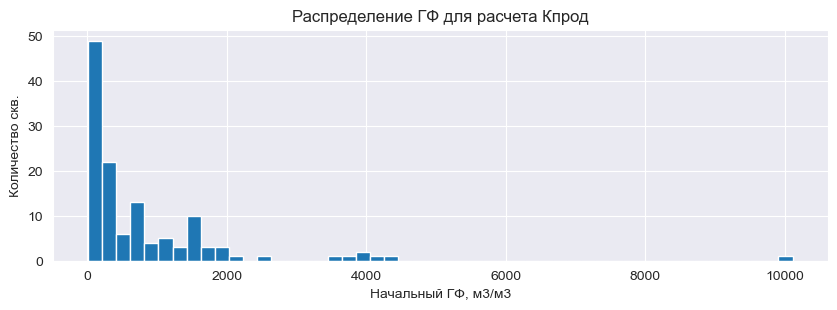

In [105]:
plt.figure(figsize=(10, 3))
pi_df['gor'].hist(bins=50)
plt.title('Распределение ГФ для расчета Кпрод')
plt.xlabel('Начальный ГФ, м3/м3')
plt.ylabel('Количество скв.')
plt.show()

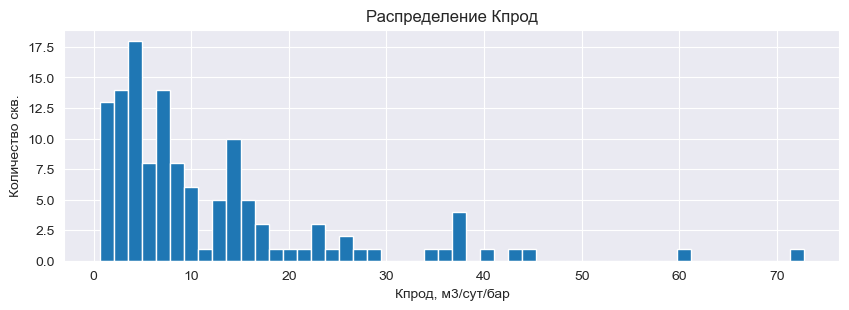

In [106]:
plt.figure(figsize=(10, 3))
pi_df['pi'].hist(bins=50)
plt.title('Распределение Кпрод')
plt.xlabel('Кпрод, м3/сут/бар')
plt.ylabel('Количество скв.')
plt.show()

In [108]:
result_df

,well_name,gdi_count,rmse,ofp_table
40,40,7,32.093255,5
4001,4001,8,14.167029,4
4001D,4001D,2,37.866363,1
4003,4003,11,8.179682,4
4024,4024,6,8.441401,1
...,...,...,...,...
4573,4573,4,30.659960,4
4574,4574,6,30.774913,5
4575,4575,2,6.852848,1
4577,4577,4,4.254749,3


In [123]:
result_df.query('rmse > 10').sort_values('rmse', ascending=False).head(50)

,well_name,gdi_count,rmse,ofp_table
4546D,4546D,1,63.552575,1
4037,4037,9,59.174909,4
4068,4068,3,57.067261,1
4143,4143,3,53.319926,1
4108,4108,2,53.253437,1
4065,4065,2,53.192603,1
4567,4567,4,47.239250,1
4045,4045,12,46.660275,5
4055,4055,5,46.347891,1
4540,4540,3,46.177752,4


In [120]:
result_df.query('rmse > 10')['well_name'].unique()

array(['40', '4001', '4001D', '4025', '4036', '4037', '4043', '4044',
       '4045', '4045D', '4054', '4055', '4057D', '4058', '4059D', '4064',
       '4065', '4065D', '4066D', '4067', '4068', '4075', '4076D', '4077D',
       '4085', '4086', '4086D', '4087D', '4096', '4096D', '4097', '4097D',
       '4099', '41', '4105', '4106', '4107', '4108', '4115', '4117',
       '4117D', '4125', '4126', '4127', '4130', '4134', '4134D', '4135',
       '4136', '4138', '4143', '4144', '4145', '4236', '4500', '4507',
       '4508', '4516', '4517', '4528', '4531', '4532D', '4539', '4540',
       '4541', '4545', '4546', '4546D', '4547D', '4548', '4556', '4558',
       '4560', '4561', '4566', '4567', '4568', '4573', '4574'],
      dtype=object)

In [109]:
print('Количество скв., по которым выполнен расчет =',
      result_df.shape[0],
      '\nКоличество скв., по которым удалось рассчитать rmse =',
      result_df[result_df['rmse'].notna()].shape[0])

Количество скв., по которым выполнен расчет = 127 
Количество скв., по которым удалось рассчитать rmse = 127


In [110]:
result_df[result_df['rmse'].isna()].sort_values(by='gdi_count', ascending=False)

,well_name,gdi_count,rmse,ofp_table


In [111]:
print('Количество скв., по которым rmse < 10 бар =',
      result_df[result_df['rmse'] < 10].shape[0],
      'скв. или',
      round(result_df[result_df['rmse'] < 10].shape[0] / result_df.shape[0] * 100),
      '%'
      )

Количество скв., по которым rmse < 10 бар = 48 скв. или 38 %


In [112]:
result_df.describe()

,gdi_count,rmse,ofp_table
count,127.000000,127.000000,127.000000
mean,4.692913,19.857619,3.086614
std,4.532969,15.719648,1.425525
min,1.000000,0.025169,1.000000
25%,2.000000,6.316889,2.000000
50%,3.000000,16.374169,3.000000
75%,5.500000,30.717436,4.000000
max,33.000000,63.552575,6.000000


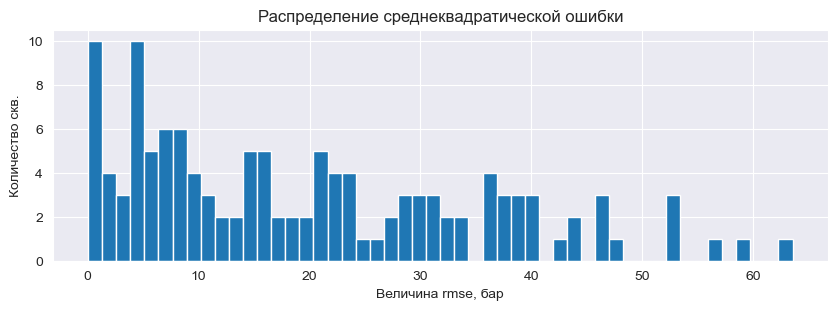

In [113]:
plt.figure(figsize=(10, 3))
result_df['rmse'].hist(bins=50)
plt.title('Распределение среднеквадратической ошибки')
plt.xlabel('Величина rmse, бар')
plt.ylabel('Количество скв.')
plt.show()

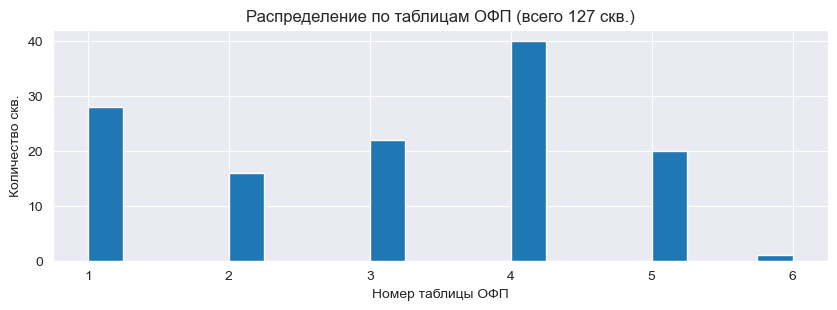

In [116]:
plt.figure(figsize=(10, 3))
result_df['ofp_table'].hist(bins=20)
cnt = result_df['ofp_table'].shape[0]
plt.title(f'Распределение по таблицам ОФП (всего {cnt} скв.)')
plt.xlabel('Номер таблицы ОФП')
plt.xticks(np.arange(1, 7, 1))
plt.ylabel('Количество скв.')
plt.show()

Сохранение результатов расчетов:

In [117]:
pi_df.to_csv('pi_df.csv', sep=';', index=False)
result_df.to_csv('result_df.csv', sep=';', index=False)

In [ ]:
Server.SetValue('GAP.EnableNetworkValidation', 1)
Server = None